In [1]:
#Data Science Project

# Importing modules

In [2]:
import os
from sklearn.tree import export_graphviz
import numpy as np
import pandas as pd
from datetime import datetime
from full_fred.fred import Fred
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
from sklearn.metrics import (accuracy_score, brier_score_loss, classification_report, 
confusion_matrix, mean_squared_error, precision_score, roc_auc_score,make_scorer,log_loss, f1_score, roc_curve, auc)
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import interpolate
from sklearn.tree import DecisionTreeClassifier
import optuna
from functools import partial
from xgboost import XGBClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import metrics
from IPython.display import Image
from sklearn.tree import plot_tree
from dotenv import load_dotenv



# Loading the data

In [3]:
#Connecting with Fred API key

load_dotenv()

os.environ["FRED_API_KEY"] = os.getenv('FRED_API_KEY')

fred = Fred()

# Checking if the API key is found in the environment
api_key_found = fred.env_api_key_found()
print(api_key_found) 


True


In [4]:
#Importing datasets

cpi_df = fred.get_series_df('CPIAUCSL',observation_start="1993-02-01", observation_end="2023-07-01", frequency = 'm')
ffrate_df = fred.get_series_df('FEDFUNDS',observation_start="1993-02-01", observation_end="2023-07-01", frequency = 'm')
gdp_df = fred.get_series_df('GDPC1',observation_start="1993-01-01", observation_end="2023-07-01", frequency = 'q')
unrate_df = fred.get_series_df('UNRATE',observation_start="1993-02-01", observation_end="2023-07-01", frequency = 'm')
indpro_df = fred.get_series_df('INDPRO',observation_start="1993-02-01", observation_end="2023-07-01", frequency = 'm')
conssen_df = fred.get_series_df('UMCSENT',observation_start="1993-02-01", observation_end="2023-07-01", frequency = 'm')
trade_df = fred.get_series_df('BOPGSTB',observation_start="1993-02-01", observation_end="2023-07-01", frequency = 'm')

#Yahoo Finance Database
spx = yf.Ticker('SPY')
vix = yf.Ticker('^VIX')
usdol= yf.Ticker('DX-Y.NYB')

spx_df = spx.history(period="1d", start="1993-02-01", end='2023-08-01', interval="1mo")
vix_df = vix.history(period="1d", start="1993-02-01", end='2023-08-01', interval="1mo")
usdol_df = usdol.history(period="1d", start="1993-02-01", end='2023-08-01', interval="1mo")

#MSCI Database
acwi = pd.read_excel('/Users/raphaelravinet/Downloads/ACWI index.xls')
#From Investing
comm_index = pd.read_csv('/Users/raphaelravinet/Downloads/Bloomberg Commodity Historical Data.csv')


In [5]:
#Open the datasets we have downloaded from Guru Focus. The are all in the same folder and they are all excel files
#So, we will bulk import them

directory = '/Users/raphaelravinet/Downloads/Code/DS'
financial_data2 = {}

for file_name in os.listdir(directory):
    if file_name.endswith('.xlsx'):  
        file_path = os.path.join(directory, file_name)
        try:
            df = pd.read_excel(file_path, engine='openpyxl')
            financial_data2[file_name] = df
        except Exception as e:
            print(f"Failed to read {file_name}: {e}")


# Preprocessing data

In [6]:
#Creating dictionaries with the data

fred_data = {'cpi' : cpi_df, 'int_rate': ffrate_df, 'gdp' : gdp_df, 
             'unemployement': unrate_df, 'indpro': indpro_df, 
             'consumer_sentiment': conssen_df, 'trade': trade_df}
financial_data = {'spx': spx_df,'vix': vix_df, 'dollar_index': usdol_df,}

In [7]:
#As these datasets have the same structure we will remove the text from the beginning of our file, filter for the relevant dates, and set them as index
#We are also resampling our data (as they were daily) and using the mean to do that


for file, df in financial_data2.items():
    df = df.iloc[:, :-1]
    df = df.iloc[4:]
    df.columns = ['Date', file.replace('.xlsx', '').replace('_', ' ')]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[(df.index > pd.Timestamp('1993-01-01')) & (df.index < pd.Timestamp('2023-07-01'))]
    df = df.sort_index(ascending=True)
    df = df.resample('M').mean()
    df.index = df.index.shift(1, freq='MS')
    financial_data2[file] = df

In [8]:
#Renaming and converting date column to date format

for name, df in fred_data.items():
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.rename(columns={'value': name}, inplace=True)

In [9]:
#Doing the same for the financial data

for name, df in financial_data.items():
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.rename(columns={'Close': name}, inplace=True)
    financial_data[name] = df.shift(1)


In [10]:
#Combining all into one dataframe. Here all the data will go through based on the index
#If just one df has a value for that particular row, all others would be NA.

all_dataframes = list(fred_data.values()) + list(financial_data.values()) + list(financial_data2.values())
combined_df = pd.concat(all_dataframes, axis=1)

In [11]:
#Checking the name of our columns
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 1993-01-01 to 2023-07-01
Freq: MS
Data columns (total 48 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   realtime_start                                         366 non-null    object 
 1   realtime_end                                           366 non-null    object 
 2   cpi                                                    366 non-null    object 
 3   realtime_start                                         366 non-null    object 
 4   realtime_end                                           366 non-null    object 
 5   int_rate                                               366 non-null    object 
 6   realtime_start                                         123 non-null    object 
 7   realtime_end                                           123 non-null    object 
 8   gdp                   

In [12]:
#Dropping columns we do not need

combined_df = combined_df.drop(columns = ['Open', 'High', 'Low', 'Stock Splits', 
                            'Capital Gains','realtime_start', 'realtime_end'])

In [13]:
#VIX, us dollar index and SPY dataframes, all have columns with the same name ('Volume' and 'Dividend'). So if we just
# try to drop using "standard" method, we will end up dropping all these columns, however 
#we don't want to drop the volume and dividends column from SPY as we will be using it in our feature engineering later on

combined_df = combined_df.loc[:,~combined_df.columns.duplicated()].copy()
combined_df

,cpi,int_rate,gdp,unemployement,indpro,consumer_sentiment,trade,spx,Volume,Dividends,vix,dollar_index,S&P 500 Earnings Yield with Forward Estimate,Shiller PE Ratio for the S&P 500,S&P 500 PE Ratio with Forward Estimate,S&P 500 Dividend Yield,BofA Merrill Lynch U.S. High Yield Total Return Index
1993-01-01,NaN,NaN,10576.275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,143.1,3.03,NaN,7.1,64.9290,86.6,-3596,NaN,NaN,NaN,NaN,NaN,4.3875,NaN,22.7995,2.848,199.415238
1993-03-01,143.3,3.07,NaN,7.0,64.8720,85.9,-6777,25.027929,5.417600e+06,0.000,13.160000,94.050003,4.378947,20.55,22.839474,2.809474,203.3115
1993-04-01,143.8,2.96,10637.847,7.1,65.0611,85.6,-6445,25.468245,3.019200e+06,0.213,12.530000,91.870003,4.354783,20.86,22.966087,2.766522,207.619565
1993-05-01,144.2,3.00,NaN,7.1,64.8104,80.3,-4369,24.933777,2.697200e+06,0.000,12.420000,89.489998,4.478095,20.46,22.341905,2.817143,209.35619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,301.744,4.65,NaN,3.5,102.6592,62,-59578.0,389.118561,1.603095e+09,0.000,20.700001,104.870003,4.257368,28.92,23.500526,1.653684,1446.3545
2023-04-01,303.032,4.83,22225.35,3.4,103.1512,63.7,-72170.0,402.011932,2.515996e+09,1.506,18.700001,102.510002,4.395217,27.95,22.755652,1.70913,1432.415217
2023-05-01,303.365,5.06,NaN,3.7,102.9240,59,-66247.0,409.992828,1.395683e+09,0.000,15.780000,101.669998,4.250526,28.76,23.529474,1.655263,1460.8435
2023-06-01,304.003,5.08,NaN,3.6,102.3002,64.2,-63532.0,411.885437,1.780706e+09,0.000,NaN,104.320000,4.269615,28.76,23.423846,1.647308,1457.282174


In [14]:
nan_val = combined_df.isnull().sum()
print(f"Number of NaN Values per Column:\n{nan_val}' ")
combined_df.info()

Number of NaN Values per Column:
cpi                                                        1
int_rate                                                   1
gdp                                                      244
unemployement                                              1
indpro                                                     1
consumer_sentiment                                         1
trade                                                      1
spx                                                        2
Volume                                                     2
Dividends                                                  2
vix                                                        4
dollar_index                                               2
S&P 500 Earnings Yield with Forward Estimate               1
Shiller PE Ratio for the S&P 500                           2
S&P 500 PE Ratio with Forward Estimate                     1
S&P 500 Dividend Yield                              

In [15]:
#Converting gdp to numeric values, and taking the percentage between the quarterly points we have available 

combined_df['gdp'] = pd.to_numeric(combined_df['gdp'], errors='coerce')
combined_df['gdp'] = combined_df['gdp'].pct_change(periods=3)

/var/folders/h1/s2xd9lx97n5g9wlqw9bdxs0w0000gn/T/ipykernel_71034/1921487741.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  combined_df['gdp'] = combined_df['gdp'].pct_change(periods=3)


In [16]:
#Forward Filling gdp

combined_df['gdp'] = combined_df['gdp'].fillna(method='ffill')
combined_df['gdp']

/var/folders/h1/s2xd9lx97n5g9wlqw9bdxs0w0000gn/T/ipykernel_71034/1417366040.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['gdp'] = combined_df['gdp'].fillna(method='ffill')


1993-01-01         NaN
1993-02-01         NaN
1993-03-01         NaN
1993-04-01    0.005822
1993-05-01    0.005822
                ...   
2023-03-01    0.005564
2023-04-01    0.005111
2023-05-01    0.005111
2023-06-01    0.005111
2023-07-01    0.011939
Freq: MS, Name: gdp, Length: 367, dtype: float64

In [17]:
#Converting everything to float so we can do some data analysis and perform some operations
combined_df = combined_df.astype(float)

In [18]:
#Renaming our columns

combined_df.rename(columns ={ 'Volume': 'spx_vol', 'S&P 500 Earnings Yield with Forward Estimate ': 'earnings_yield_FE',
       'Shiller PE Ratio for the S&P 500': 'Shiller_PE_ratio',
       'S&P 500 PE Ratio with Forward Estimate': 'PE_ratio_FE',
       'S&P 500 Dividend Yield:' : 'Dividend_yied',
       'BofA Merrill Lynch U.S. High Yield Total Return Index': 'High_yield_return'}, inplace= True)

# Adding the other 2 dataframes

In [19]:
#First let's add clean and ad the commodity index and global markets index to our dataframe.
#As they have a very different structure, it is easier to deal with them separately and then add it to the combined df

acwi.head(10)

,Unnamed: 0,Unnamed: 1
0,NaN,NaN
1,Index Level :,Price
2,Currency :,USD
3,NaN,NaN
4,NaN,NaN
5,Date,ACWI ex USA Standard (Large+Mid Cap)
6,"Dec 31, 1987",100.000
7,"Jan 29, 1988",101.536
8,"Feb 29, 1988",108.126
9,"Mar 31, 1988",114.729


In [20]:
#Slicing acwi as the first rows are text
acwi = acwi.iloc[6:-19].copy()
acwi.head()

,Unnamed: 0,Unnamed: 1
6,"Dec 31, 1987",100.000
7,"Jan 29, 1988",101.536
8,"Feb 29, 1988",108.126
9,"Mar 31, 1988",114.729
10,"Apr 29, 1988",116.245


In [21]:
#Renaming columns, converting date column to datetime and checking for null values
acwi.columns = ['Date','acwi']
acwi['Date'] = pd.to_datetime(acwi['Date'])
acwi['acwi'] = acwi['acwi'].astype(float)
acwi.set_index('Date',inplace = True)
start_date = '1993-01-01'
end_date = '2023-05-01'
acwi_clean = acwi[(acwi.index >= start_date) & (acwi.index <= end_date)].copy()
print(f"NaN values: {acwi_clean['acwi'].isnull().sum()}")
acwi_clean

NaN values: 0


,acwi
Date,
1993-01-29,101.721
1993-02-26,104.651
1993-03-31,113.075
1993-04-30,122.836
1993-05-31,125.360
...,...
2022-12-30,281.305
2023-01-31,303.953
2023-02-28,292.933


In [22]:
#ACWI value is indexed with last date of the month
#so we'll shift one day to make it the first day of the following month as the other df start with the 1st day of the month 

acwi_clean.index = acwi_clean.index + pd.offsets.MonthBegin(1)
acwi_clean.head()

,acwi
Date,
1993-02-01,101.721
1993-03-01,104.651
1993-04-01,113.075
1993-05-01,122.836
1993-06-01,125.360


In [23]:
#Now let's deal with the commodities df
comm_index.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,09/01/2023,104.8391,106.4307,108.2163,104.7907,NaN,-1.12%
1,08/01/2023,106.0289,107.3814,107.4163,103.2620,NaN,-1.22%
2,07/01/2023,107.3396,101.4910,108.3166,100.8034,NaN,5.78%
3,06/01/2023,101.4785,98.3465,105.1536,98.2207,NaN,3.59%
4,05/01/2023,97.9647,103.8325,104.3389,97.0062,NaN,-6.08%
5,04/01/2023,104.3114,106.3044,108.8917,102.7478,NaN,-1.13%
6,03/01/2023,105.5076,106.5619,108.3469,101.6154,NaN,-0.61%
7,02/01/2023,106.1591,111.8196,112.0983,104.7415,NaN,-5.05%
8,01/01/2023,111.8001,112.5637,113.1712,107.0287,NaN,-0.89%
9,12/01/2022,112.8052,116.5249,117.8104,109.5772,NaN,-2.80%


In [24]:
#Let's set the date as our index and extract Price column. Maybe we could've used %change here.

comm_index.set_index('Date', inplace = True)

comm_df = comm_index[['Price']]
comm_df = comm_df.rename(columns={'Price': 'comm_index'})
comm_df.head()

,comm_index
Date,
09/01/2023,104.8391
08/01/2023,106.0289
07/01/2023,107.3396
06/01/2023,101.4785
05/01/2023,97.9647


In [25]:
# Commodities dataframe has its values inversed so we'll reverse the DataFrame order. The first rows are values
#from 2023 and the last rows are old value.
comm_df = comm_df.iloc[::-1].copy()
comm_df.tail()

,comm_index
Date,
05/01/2023,97.9647
06/01/2023,101.4785
07/01/2023,107.3396
08/01/2023,106.0289
09/01/2023,104.8391


In [26]:
#Converting index to datetime format

comm_df.index = pd.to_datetime(comm_df.index)

In [27]:
#date here is in different format, so let's convert to be in the same format

def swap_day_month(date):
    if date.day > 12:
        return pd.Timestamp(year=date.year, month=date.day, day=date.month)
    else:
        return date

comm_df.index = comm_df.index.map(swap_day_month)


In [28]:
comm_df = comm_df.shift(1)

In [29]:
#Aligning the indexes
comm_df.loc[combined_df.index]

,comm_index
1993-01-01,89.3240
1993-02-01,88.9380
1993-03-01,89.8310
1993-04-01,91.7140
1993-05-01,92.3400
...,...
2023-03-01,106.1591
2023-04-01,105.5076
2023-05-01,104.3114
2023-06-01,97.9647


In [30]:
# Joining the dataframes on their indices
combined_df = combined_df.join(comm_df, how='left')
combined_df = combined_df.join(acwi_clean, how='left')

# Data Visualization

In [31]:
# combined_df.hist(figsize=(16,10))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.6)


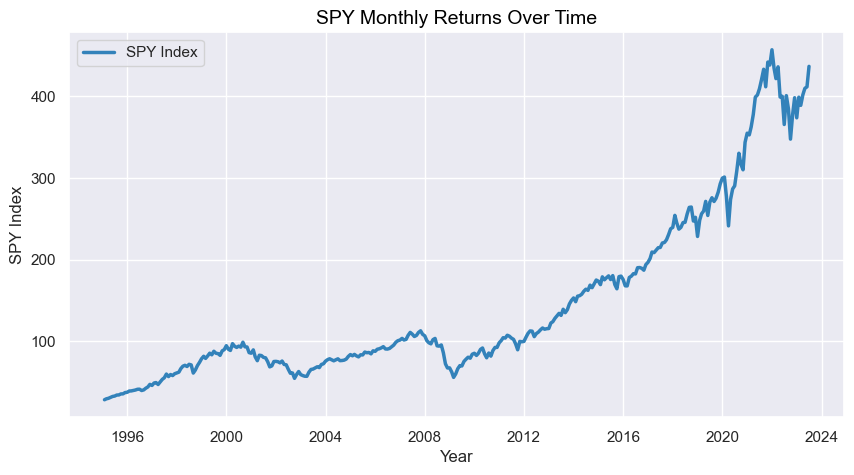

In [32]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10,5))
plt.plot(combined_df.loc[combined_df.index > '1995-01-01']['spx'], marker='', color='tab:blue', linewidth=2.5, alpha=0.9, label='SPY Index')

plt.title("SPY Monthly Returns Over Time", loc='center', fontsize=14, fontweight=0, color='black')
plt.xlabel("Year")
plt.ylabel("SPY Index")

plt.legend()
plt.show()

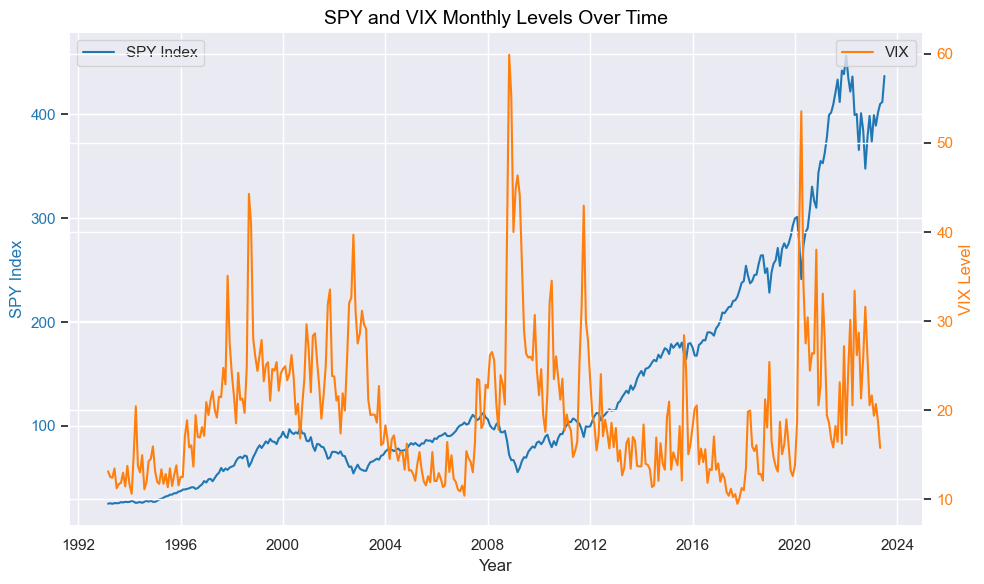

In [33]:
# Plotting VIX and SPY, to visualize periods of high volatility

sns.set_theme(style="darkgrid")


fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SPY Index', color=color)
ax1.plot(combined_df.index, combined_df['spx'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['SPY Index'], loc='upper left')

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('VIX Level', color=color)  
ax2.plot(combined_df.index, combined_df['vix'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['VIX'], loc='upper right')


plt.title("SPY and VIX Monthly Levels Over Time", loc='center', fontsize=14, fontweight=0, color='black')

fig.tight_layout()  
plt.show()


In [34]:
ohlc_df = combined_df['spx'].resample('Y').agg(['first','max', 'min', 'last'])

volume_df = combined_df['spx_vol'].resample('Y').sum()

colors = ['green' if close >= open_ else 'red' for open_, close in zip(ohlc_df['first'], ohlc_df['last'])]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.03,
                    subplot_titles=('SPY Yearly Candlestick Chart', 'Yearly Volume'),
                    row_width=[0.2, 0.7])

fig.add_trace(go.Candlestick(x=ohlc_df.index,
                             open=ohlc_df['first'],
                             high=ohlc_df['max'],
                             low=ohlc_df['min'],
                             close=ohlc_df['last'],
                             increasing_line_color='green',
                             decreasing_line_color='red'),
              row=1, col=1)

fig.add_trace(go.Bar(x=volume_df.index, y=volume_df, marker_color=colors), row=2, col=1)

fig.update_layout(title='SPY Yearly Candlestick Chart with Volume',
                  yaxis_title='SPY Price',
                  xaxis_rangeslider_visible=False,
                  showlegend=False,
                  plot_bgcolor='white')

fig.update_xaxes(title_text="<b>Year</b>", row=2, col=1)
fig.update_yaxes(title_text="<b>Volume</b>", row=2, col=1)

fig.update_layout(margin=dict(t=100, b=100))

fig.layout.annotations[0].text = 'SPY Yearly Candlestick Chart'
fig.layout.annotations[1].text = 'Yearly Volume'

fig.show()


<Axes: xlabel='Year', ylabel='SPY'>

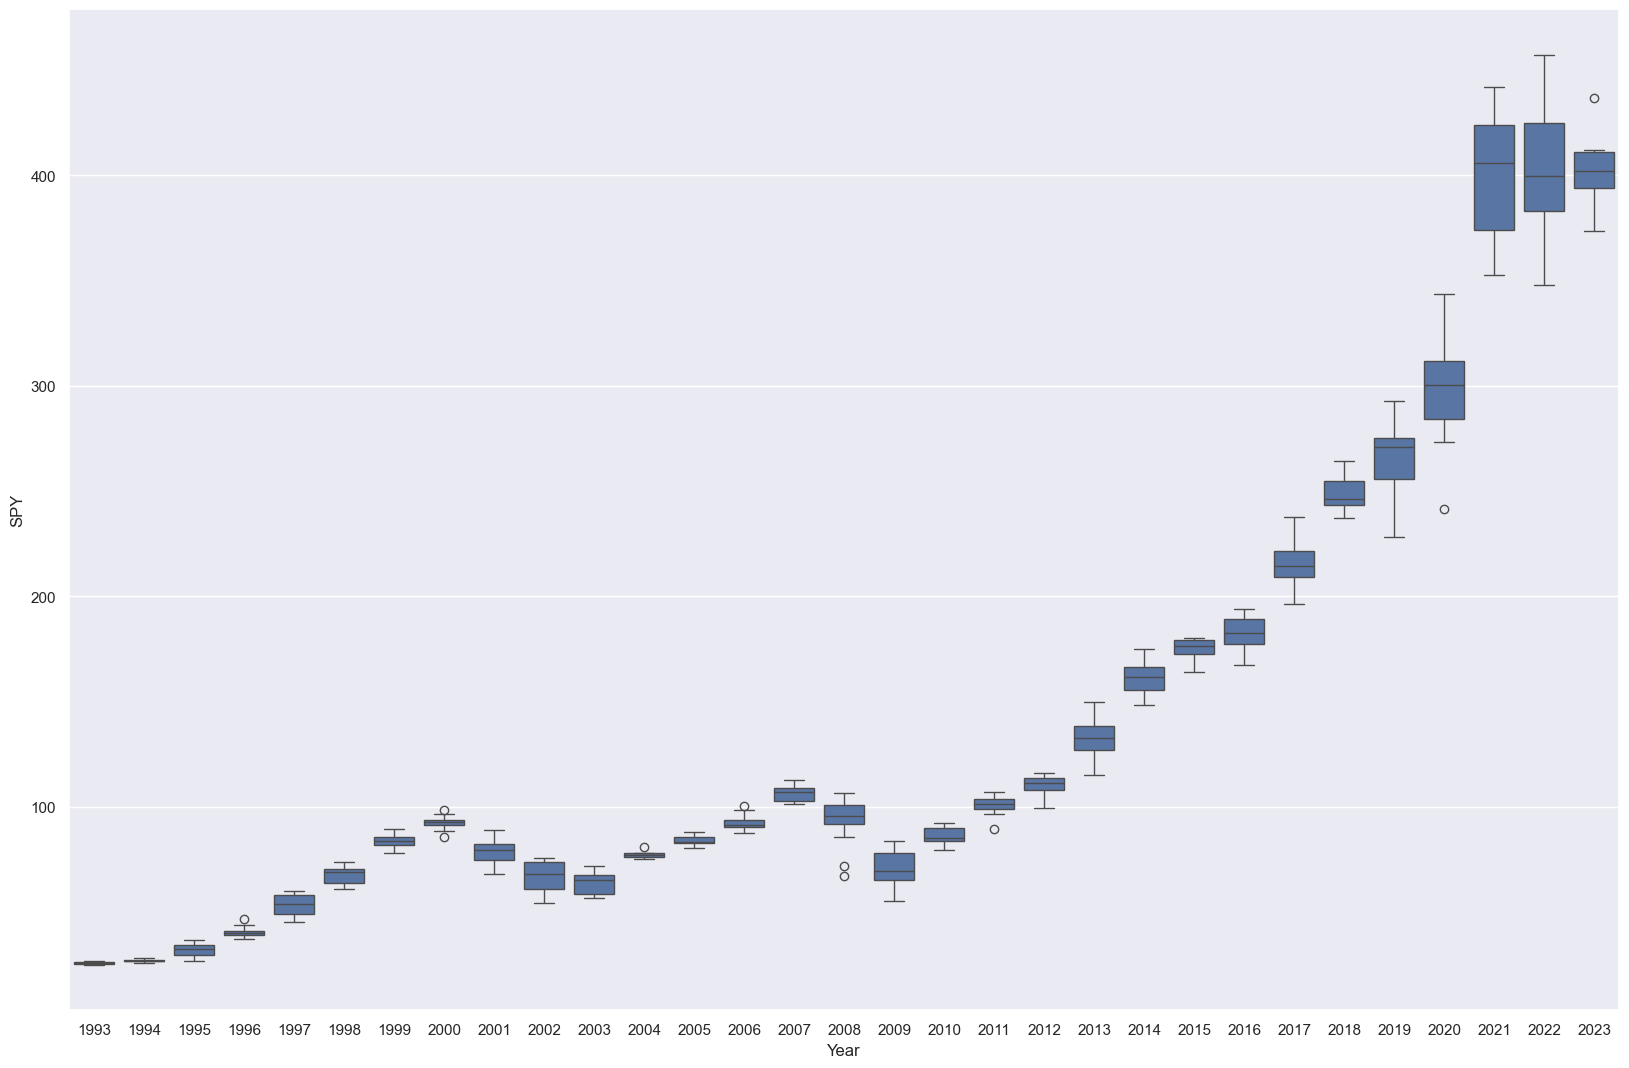

In [35]:
#Plotting SPY over time, using boxplots

plt.figure(figsize = (20,13))
plt.xlabel('Year')
plt.ylabel('SPY')
sns.boxplot(data=combined_df, x=combined_df.index.year, y=combined_df['spx'])




# Feature Engineering

In [36]:
#Making our data available one month ahead, so we do not incur in look ahead bias

projected_variables = ['cpi', 'int_rate', 'gdp', 'unemployement', 'indpro',
       'consumer_sentiment','trade']

for variable in projected_variables:
        lagged_column_name = f'{variable}_report'
        combined_df[lagged_column_name] = combined_df[variable].shift(2)



In [37]:
combined_df

,cpi,int_rate,gdp,unemployement,indpro,consumer_sentiment,trade,spx,spx_vol,Dividends,...,High_yield_return,comm_index,acwi,cpi_report,int_rate_report,gdp_report,unemployement_report,indpro_report,consumer_sentiment_report,trade_report
1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,89.3240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,143.100,3.03,NaN,7.1,64.9290,86.6,-3596.0,NaN,NaN,NaN,...,199.415238,88.9380,101.721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-03-01,143.300,3.07,NaN,7.0,64.8720,85.9,-6777.0,25.027929,5.417600e+06,0.000,...,203.311500,89.8310,104.651,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-01,143.800,2.96,0.005822,7.1,65.0611,85.6,-6445.0,25.468245,3.019200e+06,0.213,...,207.619565,91.7140,113.075,143.100,3.03,NaN,7.1,64.9290,86.6,-3596.0
1993-05-01,144.200,3.00,0.005822,7.1,64.8104,80.3,-4369.0,24.933777,2.697200e+06,0.000,...,209.356190,92.3400,122.836,143.300,3.07,NaN,7.0,64.8720,85.9,-6777.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,301.744,4.65,0.005564,3.5,102.6592,62.0,-59578.0,389.118561,1.603095e+09,0.000,...,1446.354500,106.1591,292.933,300.356,4.33,0.005564,3.4,102.5478,64.9,-70296.0
2023-04-01,303.032,4.83,0.005111,3.4,103.1512,63.7,-72170.0,402.011932,2.515996e+09,1.506,...,1432.415217,105.5076,298.679,301.509,4.57,0.005564,3.6,102.5671,66.9,-70075.0
2023-05-01,303.365,5.06,0.005111,3.7,102.9240,59.0,-66247.0,409.992828,1.395683e+09,0.000,...,1460.843500,104.3114,302.931,301.744,4.65,0.005564,3.5,102.6592,62.0,-59578.0
2023-06-01,304.003,5.08,0.005111,3.6,102.3002,64.2,-63532.0,411.885437,1.780706e+09,0.000,...,1457.282174,97.9647,NaN,303.032,4.83,0.005111,3.4,103.1512,63.7,-72170.0


In [38]:
#Creating annual cpi variable with last 12 months change
combined_df['cpi_annual'] = combined_df['cpi'].pct_change(periods=12)

In [39]:
combined_df.columns

Index(['cpi', 'int_rate', 'gdp', 'unemployement', 'indpro',
       'consumer_sentiment', 'trade', 'spx', 'spx_vol', 'Dividends', 'vix',
       'dollar_index', 'earnings_yield_FE', 'Shiller_PE_ratio', 'PE_ratio_FE',
       'S&P 500 Dividend Yield', 'High_yield_return', 'comm_index', 'acwi',
       'cpi_report', 'int_rate_report', 'gdp_report', 'unemployement_report',
       'indpro_report', 'consumer_sentiment_report', 'trade_report',
       'cpi_annual'],
      dtype='object')

In [40]:
#Creating our technical indicators

delta = combined_df['spx'].diff()

up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)

# Calculate the Exponential Moving Averages (EMA) of the gains and losses
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()

# Calculate the Relative Strength (RS)
rs = ema_up / ema_down

# Calculate the Relative Strength Index (RSI)
combined_df['RSI'] = 100 - (100 / (1 + rs))


# Short term exponential moving average (EMA)
combined_df['EMA_12'] = np.log(combined_df['spx']) - np.log(combined_df['spx']).ewm(span=12).mean()

# Long term exponential moving average (EMA)
combined_df['EMA_24'] = np.log(combined_df['spx']) - np.log(combined_df['spx']).ewm(span=24).mean()

# # MACD line
# combined_df['MACD'] = exp1 - exp2

# Signal line
# combined_df['Signal_Line'] = combined_df['MACD'].ewm(span=9, adjust=False).mean()

obv = pd.Series(index=combined_df.index, dtype='float64')
obv.iloc[0] = 0

# Calculate OBV
for i in range(1, len(combined_df)):
    if combined_df['spx'].iloc[i] > combined_df['spx'].iloc[i - 1]:
        obv.iloc[i] = obv.iloc[i - 1] + combined_df['spx_vol'].iloc[i]
    elif combined_df['spx'].iloc[i] < combined_df['spx'].iloc[i - 1]:
        obv.iloc[i] = obv.iloc[i - 1] - combined_df['spx_vol'].iloc[i]
    else:
        obv.iloc[i] = obv.iloc[i - 1]

combined_df['OBV'] = obv


# Moving Average
combined_df['MA_20'] = combined_df['spx'].rolling(window=20).mean()

# Standard Deviation
combined_df['STD_20'] = combined_df['spx'].rolling(window=20).std()



In [41]:
combined_df.columns

Index(['cpi', 'int_rate', 'gdp', 'unemployement', 'indpro',
       'consumer_sentiment', 'trade', 'spx', 'spx_vol', 'Dividends', 'vix',
       'dollar_index', 'earnings_yield_FE', 'Shiller_PE_ratio', 'PE_ratio_FE',
       'S&P 500 Dividend Yield', 'High_yield_return', 'comm_index', 'acwi',
       'cpi_report', 'int_rate_report', 'gdp_report', 'unemployement_report',
       'indpro_report', 'consumer_sentiment_report', 'trade_report',
       'cpi_annual', 'RSI', 'EMA_12', 'EMA_24', 'OBV', 'MA_20', 'STD_20'],
      dtype='object')

In [42]:
#Getting the log diff of SPY

combined_df['spx_diff'] = np.log(combined_df['spx']).diff()

In [43]:
#Below are the transformations functions we will apply to our data

def percentage_change(column):
    return column.pct_change()

def simple_diff(column):
    return column.diff()

def log_diff(column):
    return np.log(column).diff()

def identity(column):
    return column

In [44]:
#Columns that we will apply the transformations

transformations ={
    'cpi_report': percentage_change,
    'int_rate_report': simple_diff,
    'gdp_report': identity,
    'unemployement_report': simple_diff,
    'indpro_report': percentage_change,
    'consumer_sentiment_report': percentage_change,
    'trade_report': percentage_change,
    'spx_vol': log_diff,
    'vix': percentage_change,
    'dollar_index': percentage_change,
    'comm_index': percentage_change,
    'acwi': percentage_change,
    'cpi_annual': simple_diff,
    'S&P 500 Dividend Yield': log_diff,
    'EMA_12': identity,
    'EMA_24': identity,
    'earnings_yield_FE': percentage_change,
    'Shiller_PE_ratio': percentage_change,
    'PE_ratio_FE': percentage_change,
    'High_yield_return': percentage_change,
    'OBV': identity,
    'RSI': identity,
    'spx': identity,
    'spx_diff': identity,
    
}


In [45]:
transformed_columns = {}
for column, transformation in transformations.items():
    transformed_columns[column] = transformation(combined_df[column])

# Combine the results into a new DataFrame
transformed_df = pd.DataFrame(transformed_columns)
transformed_df

/var/folders/h1/s2xd9lx97n5g9wlqw9bdxs0w0000gn/T/ipykernel_71034/4262694829.py:4: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



,cpi_report,int_rate_report,gdp_report,unemployement_report,indpro_report,consumer_sentiment_report,trade_report,spx_vol,vix,dollar_index,...,EMA_12,EMA_24,earnings_yield_FE,Shiller_PE_ratio,PE_ratio_FE,High_yield_return,OBV,RSI,spx,spx_diff
1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
1993-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
1993-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,-0.001949,NaN,0.001753,0.019538,0.000000e+00,NaN,25.027929,NaN
1993-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.584661,-0.047872,-0.023179,...,0.007993,0.008357,-0.005518,0.015085,0.005544,0.021189,3.019200e+06,100.000000,25.468245,0.017440
1993-05-01,0.001398,0.04,NaN,-0.1,-0.000878,-0.008083,0.884594,-0.112778,-0.008779,-0.025906,...,-0.008058,-0.008206,0.028317,-0.019175,-0.027178,0.008364,3.220000e+05,91.460221,24.933777,-0.021209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,0.005167,0.23,0.005564,-0.1,0.010474,0.085284,-0.015269,0.017395,0.067010,0.027130,...,-0.001799,0.018582,-0.024658,0.020826,0.025239,-0.000785,5.198849e+10,51.485759,389.118561,-0.025464
2023-04-01,0.003839,0.24,0.005564,0.2,0.000188,0.030817,-0.003144,0.450733,-0.096618,-0.022504,...,0.026061,0.047085,0.032379,-0.033541,-0.031696,-0.009638,5.450449e+10,53.800415,402.011932,0.032598
2023-05-01,0.000779,0.08,0.005564,-0.1,0.000898,-0.073244,-0.149797,-0.589285,-0.156150,-0.008194,...,0.038685,0.061404,-0.032920,0.028980,0.034006,0.019846,5.590017e+10,55.224473,409.992828,0.019658
2023-06-01,0.004269,0.18,0.005111,-0.1,0.004793,0.027419,0.211353,0.243626,0.000000,0.026065,...,0.036630,0.060729,0.004491,0.000000,-0.004489,-0.002438,5.768088e+10,55.574192,411.885437,0.004606


In [46]:
#Getting the name of the original features, before lagging some of them

original_features = transformed_df.columns.tolist()

In [47]:
#Checking which columns we didn't carry it over to transformed df

set(list(combined_df.columns)) - set(list(transformed_df.columns))

{'Dividends',
 'MA_20',
 'STD_20',
 'consumer_sentiment',
 'cpi',
 'gdp',
 'indpro',
 'int_rate',
 'trade',
 'unemployement'}

In [48]:
# #Checking how correlated the variables are amongst themselves

# plt.figure(figsize=(24,18))
# features_corr = sns.heatmap(transformed_df.corr(), cmap = 'RdYlGn', annot = True)

In [49]:
transformed_df.columns

Index(['cpi_report', 'int_rate_report', 'gdp_report', 'unemployement_report',
       'indpro_report', 'consumer_sentiment_report', 'trade_report', 'spx_vol',
       'vix', 'dollar_index', 'comm_index', 'acwi', 'cpi_annual',
       'S&P 500 Dividend Yield', 'EMA_12', 'EMA_24', 'earnings_yield_FE',
       'Shiller_PE_ratio', 'PE_ratio_FE', 'High_yield_return', 'OBV', 'RSI',
       'spx', 'spx_diff'],
      dtype='object')

In [50]:
#Taking the log difference between tomorrow and today's return

transformed_df['log_ret_spy'] = np.log(transformed_df['spx']).diff().shift(-1)

In [51]:
#Creating our target variable. One without threshold and the other one with threshold.
threshold = 0.03
transformed_df['y_new'] = transformed_df['log_ret_spy'].apply(lambda x: '1' if x > threshold else '0').astype(int)
transformed_df['y'] = (transformed_df['log_ret_spy'] >= 0).astype(int)


#Creating our weight variable based on absolute return

transformed_df['weight'] = abs(transformed_df['log_ret_spy'])

In [52]:
#Lagging our variables
variables_to_lag = ['cpi_report', 'int_rate_report', 'gdp_report', 'unemployement_report', 'indpro_report',
       'consumer_sentiment_report', 'spx_diff']

max_lag = 5
for variable in variables_to_lag:
    for lag in range(1,max_lag + 1):
        lagged_column_name = f'{variable}_lag{lag}'
        transformed_df[lagged_column_name] = transformed_df[variable].shift(lag)


In [53]:
#Filtering our dataframe for the period we will be analysing 

transformed_df = transformed_df.loc[(transformed_df.index > '1995-01-01') & (transformed_df.index < '2023-05-01')].copy()

In [54]:
#Our final dataframe
print(transformed_df.isnull().sum().sum())
transformed_df

0


,cpi_report,int_rate_report,gdp_report,unemployement_report,indpro_report,consumer_sentiment_report,trade_report,spx_vol,vix,dollar_index,...,consumer_sentiment_report_lag1,consumer_sentiment_report_lag2,consumer_sentiment_report_lag3,consumer_sentiment_report_lag4,consumer_sentiment_report_lag5,spx_diff_lag1,spx_diff_lag2,spx_diff_lag3,spx_diff_lag4,spx_diff_lag5
1995-02-01,0.002003,0.16,0.011456,-0.1,0.010003,0.038210,-0.120541,-1.129968,-0.093939,-0.008340,...,-0.011866,0.013115,-0.002181,0.030337,-0.024123,-0.000686,-0.040630,0.034094,-0.031644,0.037413
1995-03-01,0.002665,0.08,0.003548,0.1,0.001896,0.026288,0.102649,0.766073,-0.017559,-0.023412,...,0.038210,-0.011866,0.013115,-0.002181,0.030337,0.040998,-0.000686,-0.040630,0.034094,-0.031644
1995-04-01,0.002658,0.39,0.003548,-0.2,-0.001204,-0.025615,-0.054376,-0.271711,0.137872,-0.046899,...,0.026288,0.038210,-0.011866,0.013115,-0.002181,0.039999,0.040998,-0.000686,-0.040630,0.034094
1995-05-01,0.001988,0.06,0.003548,0.0,0.001386,-0.050473,0.101055,-0.031973,-0.121167,-0.001221,...,-0.025615,0.026288,0.038210,-0.011866,0.013115,0.022069,0.039999,0.040998,-0.000686,-0.040630
1995-06-01,0.003968,0.07,0.002983,0.4,-0.001779,0.024363,-0.010198,0.463424,0.093617,0.009413,...,-0.050473,-0.025615,0.026288,0.038210,-0.011866,0.034591,0.022069,0.039999,0.040998,-0.000686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.005136,0.52,0.006354,0.1,-0.001129,0.022184,0.092059,-0.148118,-0.204791,-0.050031,...,0.006873,0.130097,0.030000,-0.143836,-0.104294,0.082241,-0.101101,-0.041658,0.092401,-0.090370
2023-01-01,0.002635,0.70,0.006354,0.0,-0.003295,-0.053422,-0.185257,-0.005751,0.052964,-0.022935,...,0.022184,0.006873,0.130097,0.030000,-0.143836,0.054101,0.082241,-0.101101,-0.041658,0.092401
2023-02-01,0.000549,0.32,0.006354,-0.1,-0.015387,0.054674,0.118587,-0.097027,-0.104753,-0.013717,...,-0.053422,0.022184,0.006873,0.130097,0.030000,-0.063937,0.054101,0.082241,-0.101101,-0.041658
2023-03-01,0.005167,0.23,0.005564,-0.1,0.010474,0.085284,-0.015269,0.017395,0.067010,0.027130,...,0.054674,-0.053422,0.022184,0.006873,0.130097,0.065571,-0.063937,0.054101,0.082241,-0.101101


In [55]:
transformed_df.columns

Index(['cpi_report', 'int_rate_report', 'gdp_report', 'unemployement_report',
       'indpro_report', 'consumer_sentiment_report', 'trade_report', 'spx_vol',
       'vix', 'dollar_index', 'comm_index', 'acwi', 'cpi_annual',
       'S&P 500 Dividend Yield', 'EMA_12', 'EMA_24', 'earnings_yield_FE',
       'Shiller_PE_ratio', 'PE_ratio_FE', 'High_yield_return', 'OBV', 'RSI',
       'spx', 'spx_diff', 'log_ret_spy', 'y_new', 'y', 'weight',
       'cpi_report_lag1', 'cpi_report_lag2', 'cpi_report_lag3',
       'cpi_report_lag4', 'cpi_report_lag5', 'int_rate_report_lag1',
       'int_rate_report_lag2', 'int_rate_report_lag3', 'int_rate_report_lag4',
       'int_rate_report_lag5', 'gdp_report_lag1', 'gdp_report_lag2',
       'gdp_report_lag3', 'gdp_report_lag4', 'gdp_report_lag5',
       'unemployement_report_lag1', 'unemployement_report_lag2',
       'unemployement_report_lag3', 'unemployement_report_lag4',
       'unemployement_report_lag5', 'indpro_report_lag1', 'indpro_report_lag2',
     

In [56]:
#Splitting into Train and test. Here we are leaving the last 40 observations for testing.
#Not that this is not our cross validation split, we will further split our train set here into multiple train and
#tests.
transformed_df_train = transformed_df.iloc[:-40].copy()
transformed_df_test = transformed_df.iloc[-40:].copy() 
transformed_df_train.columns

Index(['cpi_report', 'int_rate_report', 'gdp_report', 'unemployement_report',
       'indpro_report', 'consumer_sentiment_report', 'trade_report', 'spx_vol',
       'vix', 'dollar_index', 'comm_index', 'acwi', 'cpi_annual',
       'S&P 500 Dividend Yield', 'EMA_12', 'EMA_24', 'earnings_yield_FE',
       'Shiller_PE_ratio', 'PE_ratio_FE', 'High_yield_return', 'OBV', 'RSI',
       'spx', 'spx_diff', 'log_ret_spy', 'y_new', 'y', 'weight',
       'cpi_report_lag1', 'cpi_report_lag2', 'cpi_report_lag3',
       'cpi_report_lag4', 'cpi_report_lag5', 'int_rate_report_lag1',
       'int_rate_report_lag2', 'int_rate_report_lag3', 'int_rate_report_lag4',
       'int_rate_report_lag5', 'gdp_report_lag1', 'gdp_report_lag2',
       'gdp_report_lag3', 'gdp_report_lag4', 'gdp_report_lag5',
       'unemployement_report_lag1', 'unemployement_report_lag2',
       'unemployement_report_lag3', 'unemployement_report_lag4',
       'unemployement_report_lag5', 'indpro_report_lag1', 'indpro_report_lag2',
     

In [57]:
transformed_df_train

,cpi_report,int_rate_report,gdp_report,unemployement_report,indpro_report,consumer_sentiment_report,trade_report,spx_vol,vix,dollar_index,...,consumer_sentiment_report_lag1,consumer_sentiment_report_lag2,consumer_sentiment_report_lag3,consumer_sentiment_report_lag4,consumer_sentiment_report_lag5,spx_diff_lag1,spx_diff_lag2,spx_diff_lag3,spx_diff_lag4,spx_diff_lag5
1995-02-01,0.002003,0.16,0.011456,-0.1,0.010003,0.038210,-0.120541,-1.129968,-0.093939,-0.008340,...,-0.011866,0.013115,-0.002181,0.030337,-0.024123,-0.000686,-0.040630,0.034094,-0.031644,0.037413
1995-03-01,0.002665,0.08,0.003548,0.1,0.001896,0.026288,0.102649,0.766073,-0.017559,-0.023412,...,0.038210,-0.011866,0.013115,-0.002181,0.030337,0.040998,-0.000686,-0.040630,0.034094,-0.031644
1995-04-01,0.002658,0.39,0.003548,-0.2,-0.001204,-0.025615,-0.054376,-0.271711,0.137872,-0.046899,...,0.026288,0.038210,-0.011866,0.013115,-0.002181,0.039999,0.040998,-0.000686,-0.040630,0.034094
1995-05-01,0.001988,0.06,0.003548,0.0,0.001386,-0.050473,0.101055,-0.031973,-0.121167,-0.001221,...,-0.025615,0.026288,0.038210,-0.011866,0.013115,0.022069,0.039999,0.040998,-0.000686,-0.040630
1995-06-01,0.003968,0.07,0.002983,0.4,-0.001779,0.024363,-0.010198,0.463424,0.093617,0.009413,...,-0.050473,-0.025615,0.026288,0.038210,-0.011866,0.034591,0.022069,0.039999,0.040998,-0.000686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,-0.000325,-0.01,0.008297,0.0,0.000684,-0.018000,-0.035485,-0.188542,0.068966,0.024862,...,0.028807,-0.012195,0.049041,0.028509,-0.072228,0.062420,-0.065895,0.044435,0.013544,0.031901
2019-09-01,0.002308,0.02,0.011322,0.1,-0.004544,0.002037,-0.004720,0.605554,0.177419,0.004060,...,-0.018000,0.028807,-0.012195,0.049041,0.028509,0.019858,0.062420,-0.065895,0.044435,0.013544
2019-10-01,0.000915,-0.27,0.011322,-0.1,0.007369,-0.087398,0.005716,-0.444701,-0.144362,0.004650,...,0.002037,-0.018000,0.028807,-0.012195,0.049041,-0.016885,0.019858,0.062420,-0.065895,0.044435
2019-11-01,0.001539,-0.09,0.011322,-0.1,-0.002373,0.037862,-0.082837,0.061656,-0.185961,-0.020427,...,-0.087398,0.002037,-0.018000,0.028807,-0.012195,0.014664,-0.016885,0.019858,0.062420,-0.065895


In [58]:
features_to_plot = ['cpi_report', 'int_rate_report', 'gdp_report', 'unemployement_report', 'indpro_report',
       'consumer_sentiment_report', 'trade_report', 'spx_vol', 'dollar_index','comm_index', 'y_new']
features_to_plot_df = transformed_df[features_to_plot]

In [59]:
feature_to_plot_mapping = {
    'cpi_report': 'CPI',
    'comm_index': 'Commodity_index',
    'consumer_sentiment_report': 'Sentiment_index',
    'dollar_index': 'Dollar_index',
    'gdp_report': 'GDP',
    'indpro_report': 'Ind_production',
    'int_rate_report': 'Int_rate',
    'spx_vol': 'SPY Volume',
    'trade_report': 'Trade Balance',
    'unemployement_report': 'Unemployement_rate',}

In [60]:
feature_to_plot_mapping

{'cpi_report': 'CPI',
 'comm_index': 'Commodity_index',
 'consumer_sentiment_report': 'Sentiment_index',
 'dollar_index': 'Dollar_index',
 'gdp_report': 'GDP',
 'indpro_report': 'Ind_production',
 'int_rate_report': 'Int_rate',
 'spx_vol': 'SPY Volume',
 'trade_report': 'Trade Balance',
 'unemployement_report': 'Unemployement_rate'}

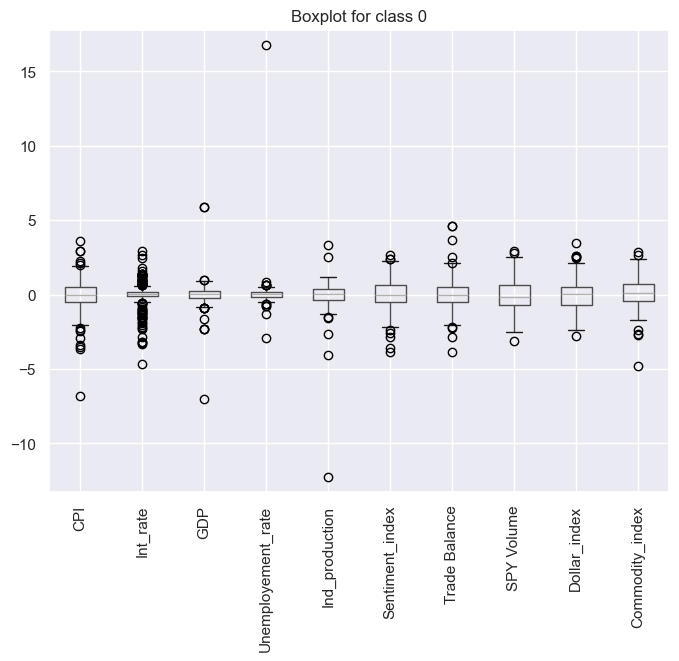

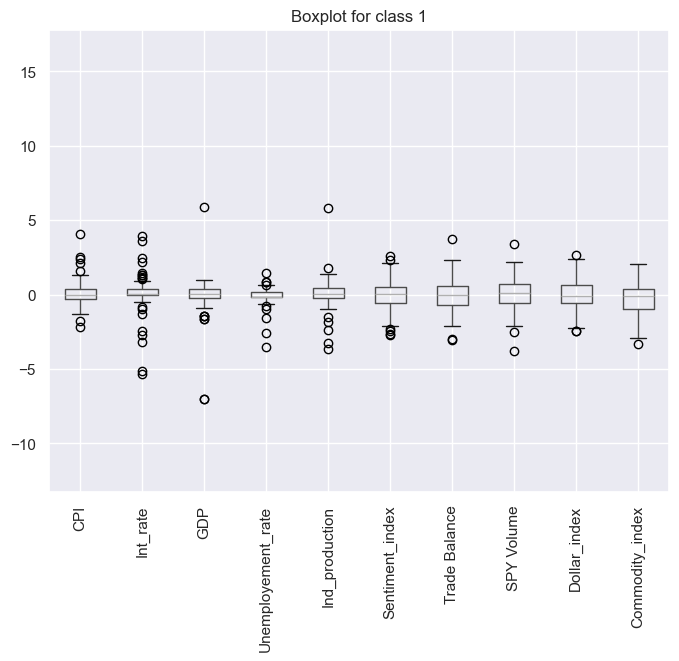

In [61]:
X_to_plot = features_to_plot_df.drop('y_new', axis=1)
y_to_plot = features_to_plot_df['y_new']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_to_plot)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_to_plot.columns, index=X_to_plot.index)
X_scaled_df['y_new'] = y_to_plot

X_scaled_df_renamed = X_scaled_df.rename(columns=feature_to_plot_mapping)


y_min = X_scaled_df.drop('y_new', axis=1).min().min() - 1
y_max = X_scaled_df.drop('y_new', axis=1).max().max() + 1

grouped_renamed = X_scaled_df_renamed.groupby('y_new')
for name, group in grouped_renamed:
    fig, ax = plt.subplots(figsize=(8, 6))  
    group.drop('y_new', axis=1).boxplot(rot=90, ax=ax)
    ax.set_ylim(y_min, y_max)  
    plt.title(f'Boxplot for class {name}')
    plt.show()

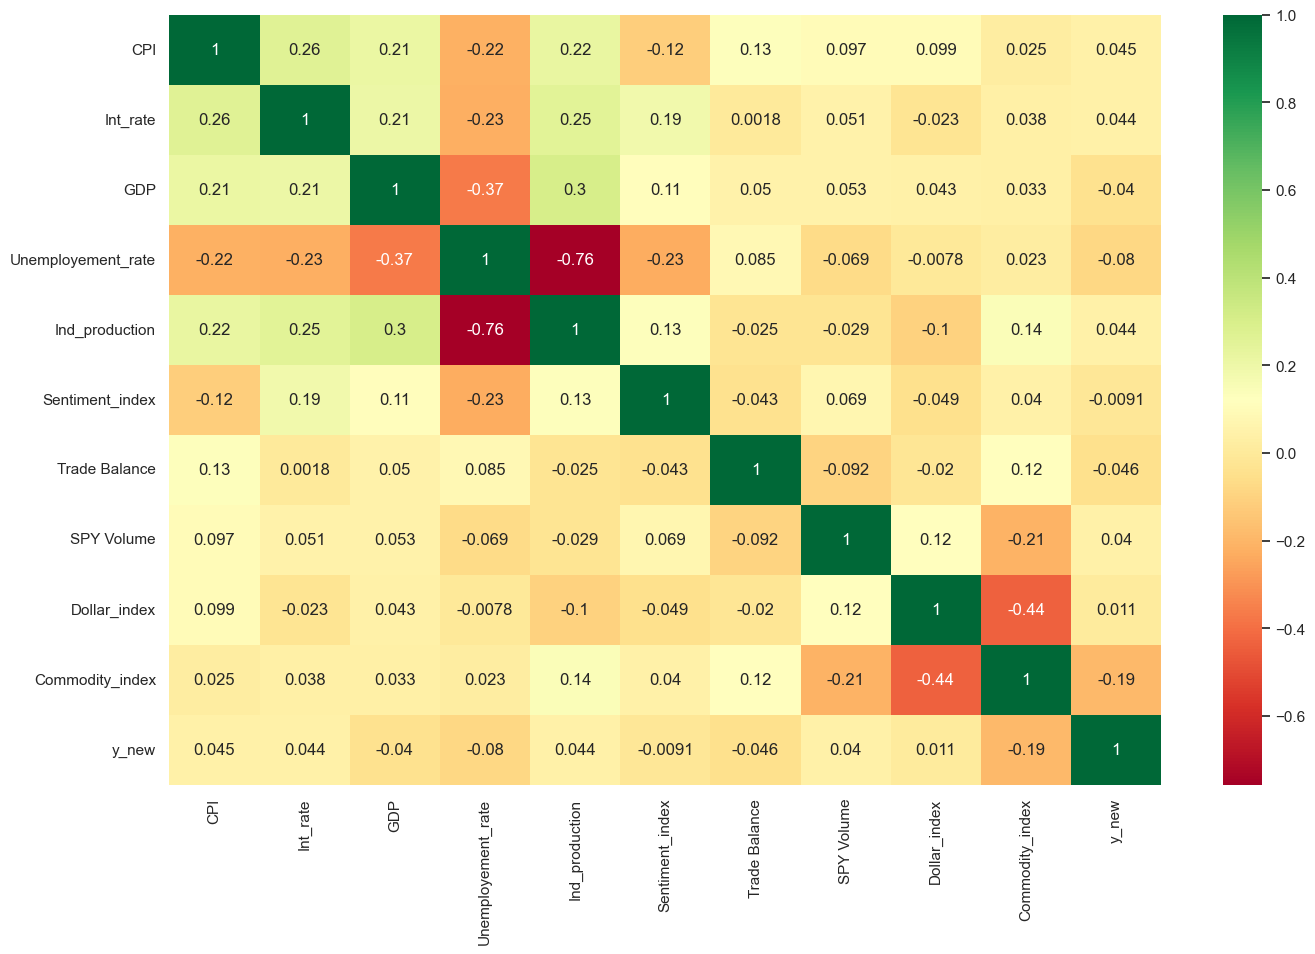

In [62]:
#Checking how correlated the variables are amongst themselves

plt.figure(figsize=(16,10))
features_corr = sns.heatmap(X_scaled_df_renamed.corr(), cmap = 'RdYlGn', annot = True)

In [63]:
#Extracting the features we will use as our independent variable
features =['cpi_report', 'int_rate_report', 'gdp_report', 'unemployement_report',
       'indpro_report', 'consumer_sentiment_report', 'trade_report', 'spx_vol',
       'dollar_index', 'comm_index', 'acwi', 'cpi_annual',
       'S&P 500 Dividend Yield', 'EMA_12', 'EMA_24', 'earnings_yield_FE',
       'Shiller_PE_ratio', 'PE_ratio_FE', 'OBV', 'RSI',
       'spx_diff','cpi_report_lag1', 'cpi_report_lag2',
       'cpi_report_lag3', 'cpi_report_lag4', 'cpi_report_lag5',
       'int_rate_report_lag1', 'int_rate_report_lag2', 'int_rate_report_lag3',
       'int_rate_report_lag4', 'int_rate_report_lag5', 'gdp_report_lag1',
       'gdp_report_lag2', 'gdp_report_lag3', 'gdp_report_lag4',
       'gdp_report_lag5', 'unemployement_report_lag1',
       'unemployement_report_lag2', 'unemployement_report_lag3',
       'unemployement_report_lag4', 'unemployement_report_lag5',
       'indpro_report_lag1', 'indpro_report_lag2', 'indpro_report_lag3',
       'indpro_report_lag4', 'indpro_report_lag5',
       'consumer_sentiment_report_lag1', 'consumer_sentiment_report_lag2',
       'consumer_sentiment_report_lag3', 'consumer_sentiment_report_lag4',
       'consumer_sentiment_report_lag5', 'spx_diff_lag1', 'spx_diff_lag2',
       'spx_diff_lag3', 'spx_diff_lag4', 'spx_diff_lag5',
          'High_yield_return']

In [64]:
#Defining X variable according to our features
X = transformed_df_train[features]
X_test = transformed_df_test[features]

#Defining weight variable for train and test set
weight_train = transformed_df_train['weight']
weight_test = transformed_df_test['weight']

#Defining Y variable for train and test set
y_new = transformed_df_train['y_new']
y_new_test = transformed_df_test['y_new']
y = transformed_df_train['y']
y_test = transformed_df_test['y']

In [65]:
#Creating graph for monthly return distribution
positive_above_3 = transformed_df[transformed_df['y_new'] == 1].copy()

positive_above_3['Year'] = positive_above_3.index.year.copy()

grouped = positive_above_3.groupby('Year').size().reset_index(name='counts').copy()

fig = go.Figure(data=[
    go.Bar(name='Positive Above 3%', x=grouped['Year'], y=grouped['counts'], marker_color='green')
])

fig.update_layout(title='Distribution of Monthly Returns Above 3% for S&P 500 Over Time',
                  xaxis_title='Year', yaxis_title='Number of Months')

fig.show()


/var/folders/h1/s2xd9lx97n5g9wlqw9bdxs0w0000gn/T/ipykernel_71034/1429974223.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




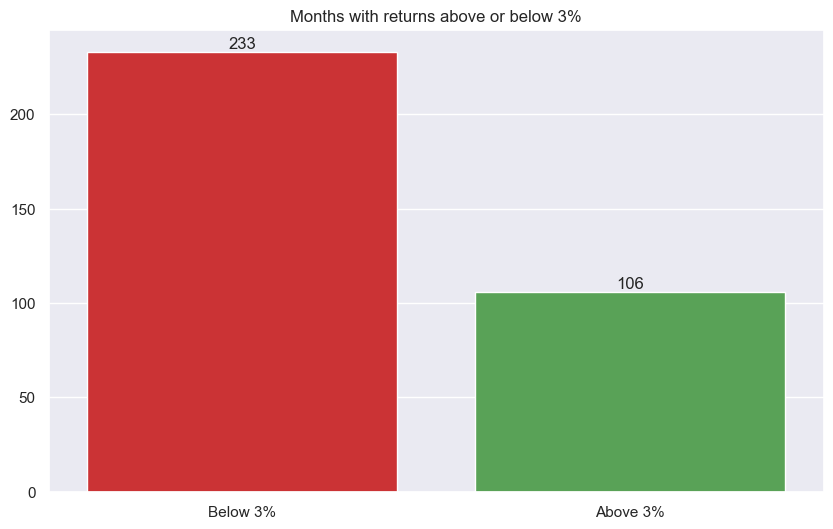

In [66]:
#This will display our class imbalance

classes, counts = np.unique(y_to_plot, return_counts=True)

classes = ['Below 3%', 'Above 3%']
counts_list = [counts[0], counts[1]]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=classes, y=counts_list, palette=['#e41a1c', '#4daf4a'])

for i, count in enumerate(counts_list):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.title('Months with returns above or below 3%')
plt.show()


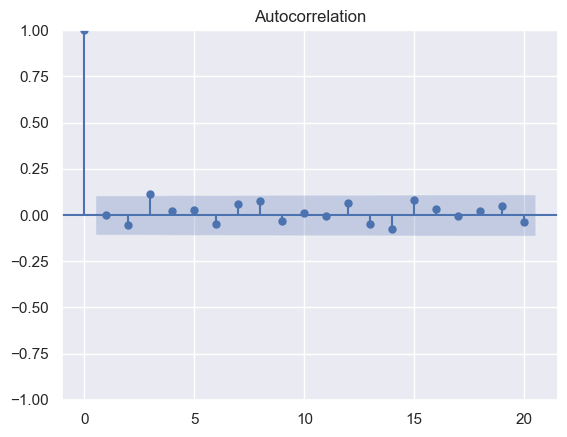

In [67]:
#Checking if the previous return of S&P500 influence the current returns 

plot_acf(transformed_df['log_ret_spy'], lags=20) 
plt.show()

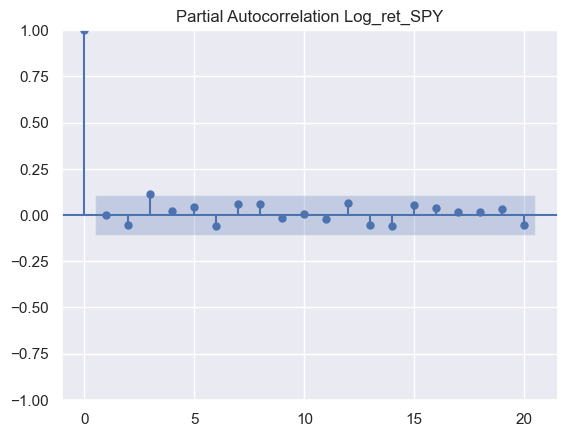

In [68]:
plot_pacf(transformed_df['log_ret_spy'], lags=20)
plt.title('Partial Autocorrelation Log_ret_SPY')
plt.show()

# Cross Validation

In [69]:
#Creating a dictionary with the models we will use. We will pass this on to the cross validation function

binary_models = {
    'LogisticRegression': LogisticRegression,
    'RandomForest': RandomForestClassifier,
    'GradientBoosting': GradientBoostingClassifier,
    'XGB': XGBClassifier
}

In [70]:
#Defining our cross validation function. In this function we will pass the models we want to test, our X and y
#our weights and the number of splits in which we will split our data into training and test sets.
#We also have an optional argument which is the parameters that we may pass to our models.
#We will run first to get our baseline model

def time_series_validation_binary(model_classes, X, y, n_splits,weights = None,random_state = 50, model_configs=None):
    model_scores = {}
    feature_importance_dfs = {}
    y_proba_cv = {}
    roc_data = {}

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for name, model_class in model_classes.items():
        config = model_configs.get(name, {}) if model_configs is not None else {}
        config['random_state'] = random_state

        # Initialize metrics
        accuracies = []
        log_losses = []
        importances = []
        all_importances = []
        aggregated_cm = np.zeros((2, 2), dtype=int)
        auc_scores = []
        y_proba_model = []
        split_indices = [] 
        roc_data[name] = {'fpr': [], 'tpr': [], 'auc': []}  

        for train_index, test_index in tscv.split(X):
            split_indices.append((train_index, test_index))
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            sample_weight_train = weights.iloc[train_index] if weights is not None else None
            sample_weight_test = weights.iloc[test_index] if weights is not None else None

            # Scaling the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Fitting the model - using parameters if we pass them on
            model = model_class(**config)
            model.fit(X_train_scaled, y_train, sample_weight=sample_weight_train)
            if name == 'RandomForest':  
                estimator = model.estimators_[0]
                
                export_graphviz(estimator, out_file=f'{name}_tree.dot', 
                                feature_names=X.columns,
                                rounded=True, proportion=False, 
                                precision=2, filled=True)
                os.system(f'dot -Tpng {name}_tree.dot -o {name}_tree.png')

        
            
            y_proba = model.predict_proba(X_test_scaled)
            y_proba_model.append(y_proba[:, 1])
            
            fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1], sample_weight=sample_weight_test)
            roc_auc = auc(fpr, tpr)

            # Storing feature importances if available - not all models would get that
            if hasattr(model, 'feature_importances_'):
                all_importances.append(model.feature_importances_)

            # Calculate and store evaluation metrics - we might not need to use log loss
            log_loss_score = log_loss(y_test, y_proba, sample_weight=sample_weight_test)
            log_losses.append(log_loss_score)
            accuracies.append(accuracy_score(y_test, model.predict(X_test_scaled)))
            auc_score = roc_auc_score(y_test, y_proba[:, 1], sample_weight=sample_weight_test)
            auc_scores.append(auc_score)
            roc_data[name]['fpr'].append(fpr)
            roc_data[name]['tpr'].append(tpr)
            roc_data[name]['auc'].append(roc_auc)

            # Update the aggregated confusion matrix
            cm = confusion_matrix(y_test, model.predict(X_test_scaled), labels=[0, 1])
            aggregated_cm += cm

        # Calculate average metrics
        avg_log_loss = np.mean(log_losses)
        avg_accuracy = np.mean(accuracies)
        avg_auc = np.mean(auc_scores)

        # Aggregate feature importances and store in DataFrame
        if all_importances:
            avg_importance = np.mean(all_importances, axis=0)
            feature_importance_df = pd.DataFrame({
                'Feature': X.columns,
                f'{name}_Importance': avg_importance
            })
            feature_importance_dfs[name] = feature_importance_df

        # Store the final results
        model_scores[name] = {
            'Average Accuracy': avg_accuracy,
            'Average Log Loss': avg_log_loss,
            'Average AUC': avg_auc,
            'Aggregated Confusion Matrix': aggregated_cm
        }
        y_proba_cv[name] = y_proba_model
        
        
        

    return model_scores, feature_importance_dfs, y_proba_cv, split_indices, roc_data


In [71]:
#Storing the results from CV

scores, feature_importances, y_proba_cvv,split_indices, roc_data = time_series_validation_binary(
    model_classes=binary_models, 
    X=X, 
    y=y_new,
    n_splits= 5,
    weights = weight_train
)

In [72]:
scores

{'LogisticRegression': {'Average Accuracy': 0.5755102040816327,
  'Average Log Loss': 0.9747114156113031,
  'Average AUC': 0.5193840742010195,
  'Aggregated Confusion Matrix': array([[114,  69],
         [ 35,  27]])},
 'RandomForest': {'Average Accuracy': 0.710204081632653,
  'Average Log Loss': 0.7199757902000695,
  'Average AUC': 0.5484376393878209,
  'Aggregated Confusion Matrix': array([[165,  18],
         [ 53,   9]])},
 'GradientBoosting': {'Average Accuracy': 0.616326530612245,
  'Average Log Loss': 1.2068285900675948,
  'Average AUC': 0.5529460879597698,
  'Aggregated Confusion Matrix': array([[131,  52],
         [ 42,  20]])},
 'XGB': {'Average Accuracy': 0.4530612244897959,
  'Average Log Loss': 0.7198954055660758,
  'Average AUC': 0.5298479993539413,
  'Aggregated Confusion Matrix': array([[ 70, 113],
         [ 21,  41]])}}

In [73]:
#Storing roc data for ROC curve graph
rf_rocdata = roc_data['RandomForest']
lr_rocdata = roc_data['LogisticRegression']
gb_rocdata = roc_data['GradientBoosting']
xgb_rocdata = roc_data['XGB']

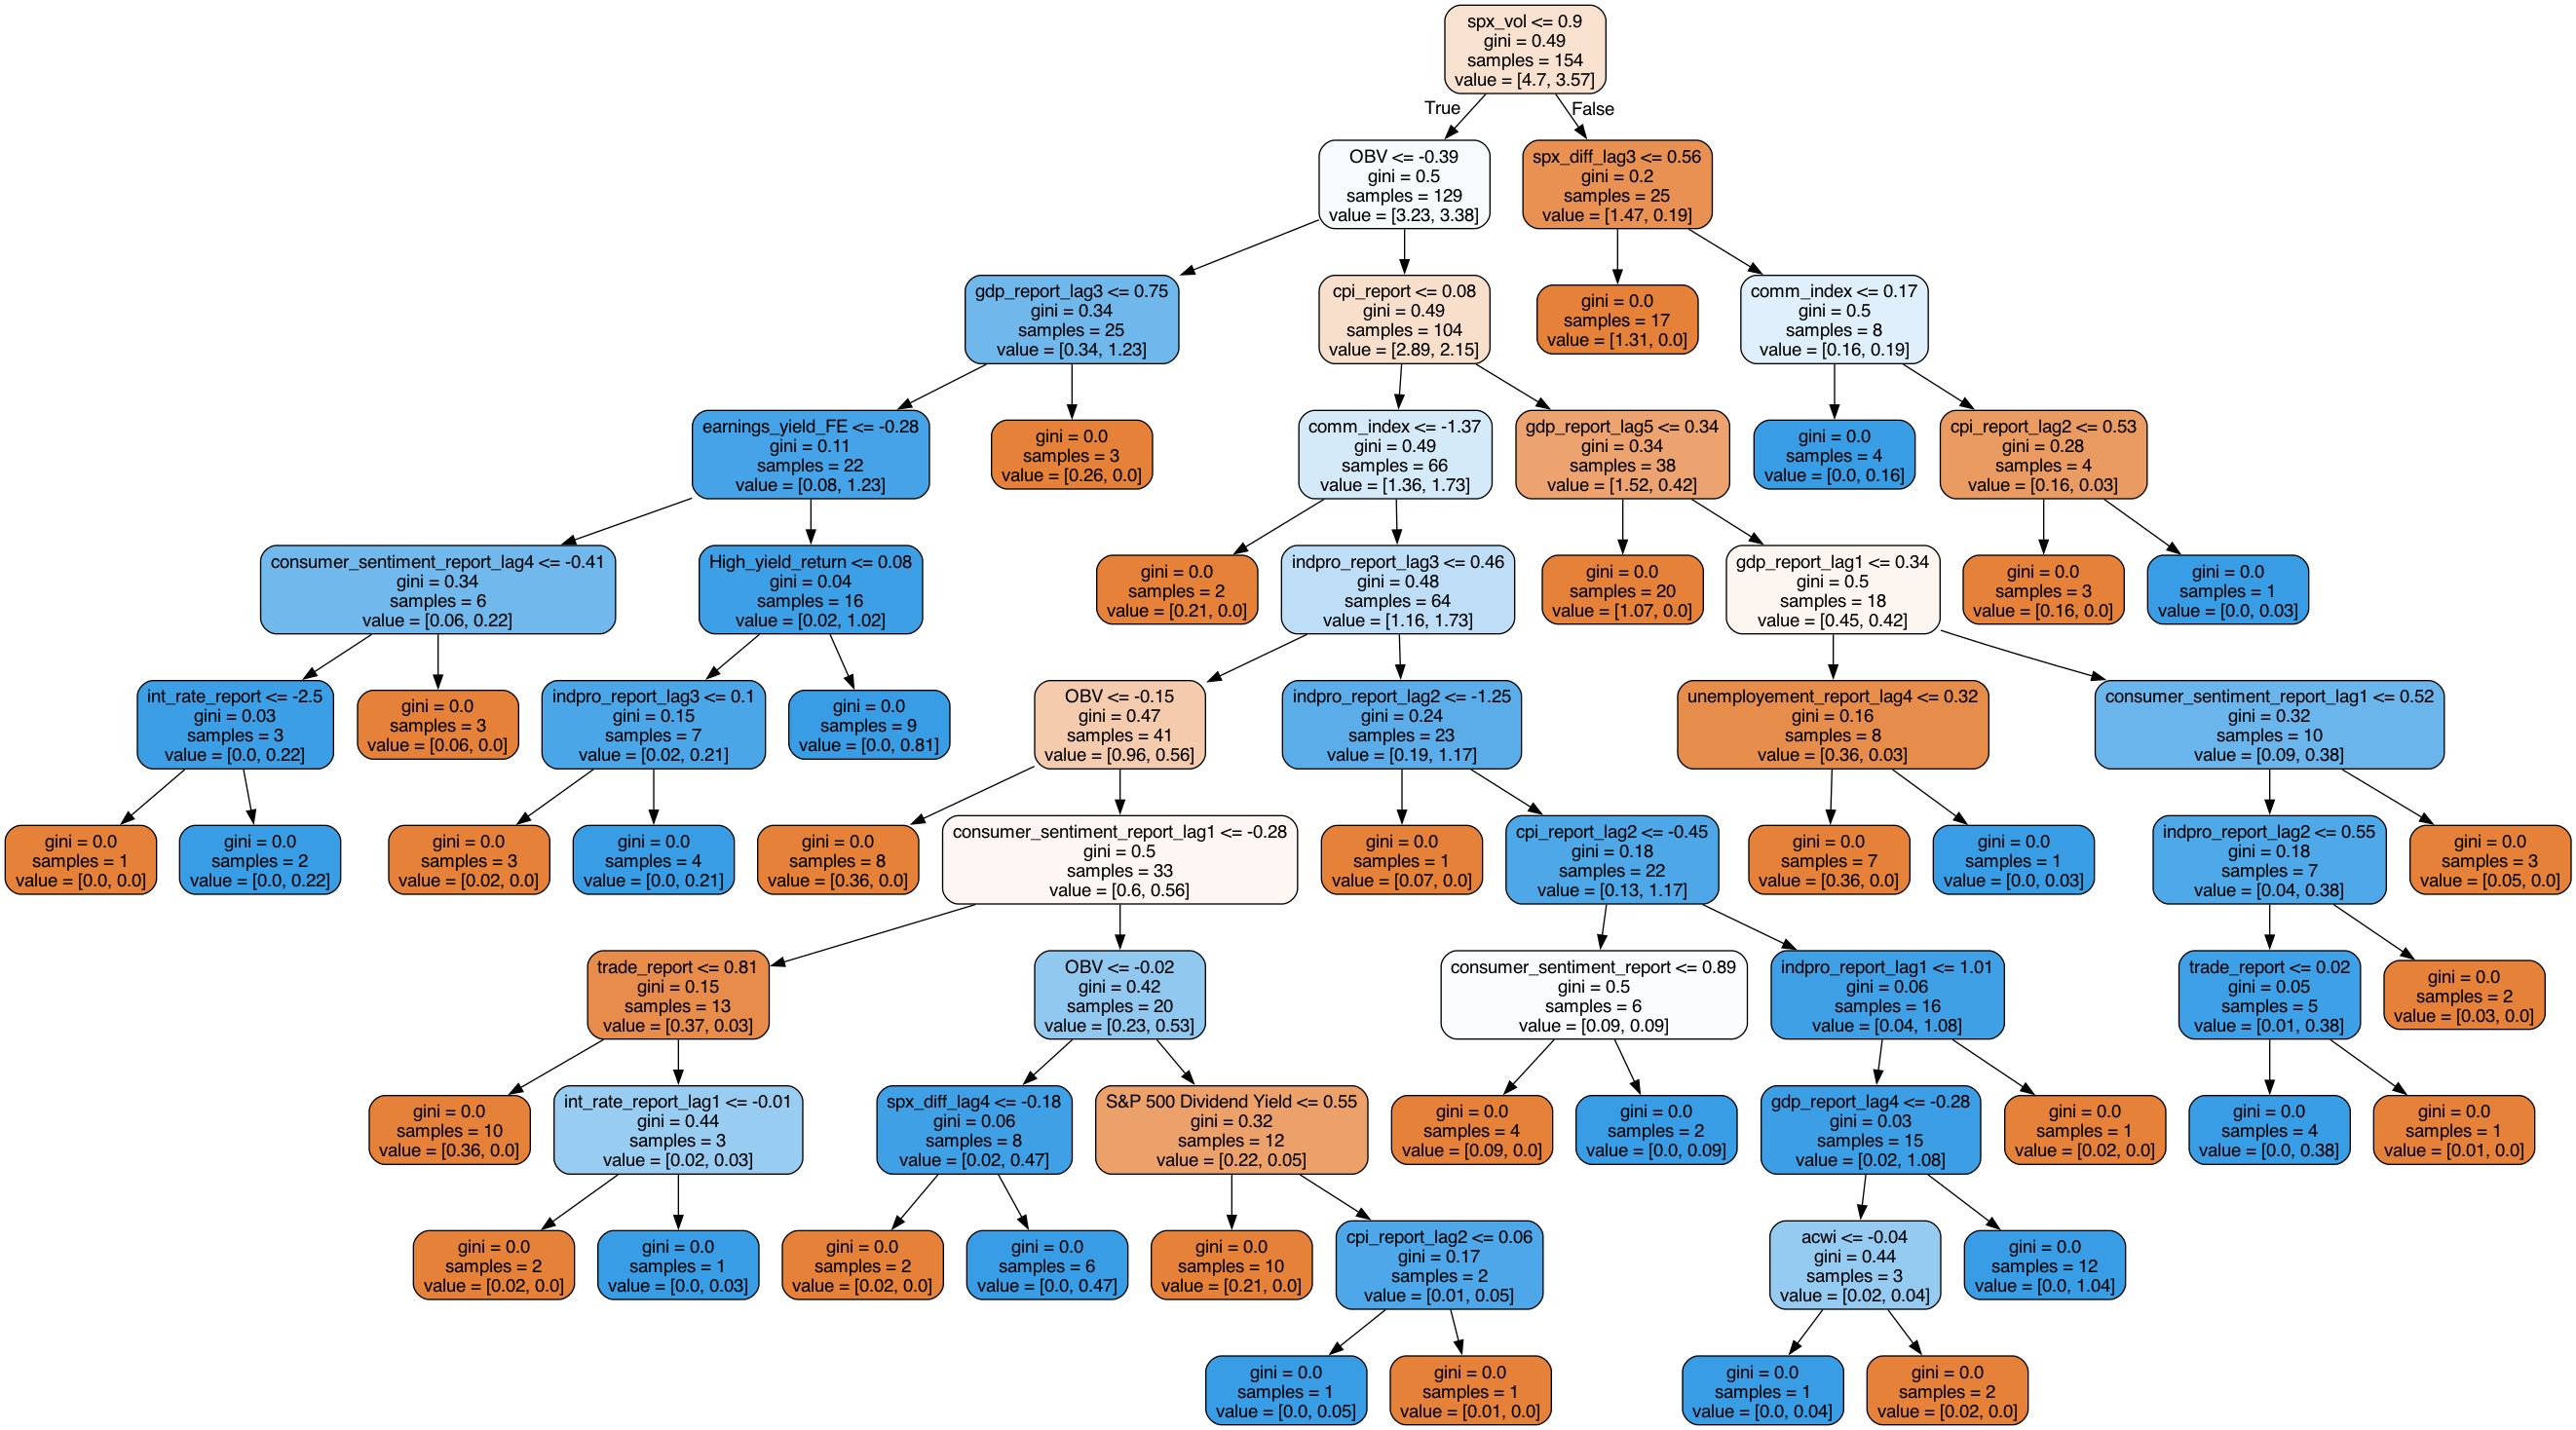

In [74]:
#Displaying from Random Forest tree

Image(filename='RandomForest_tree.png')

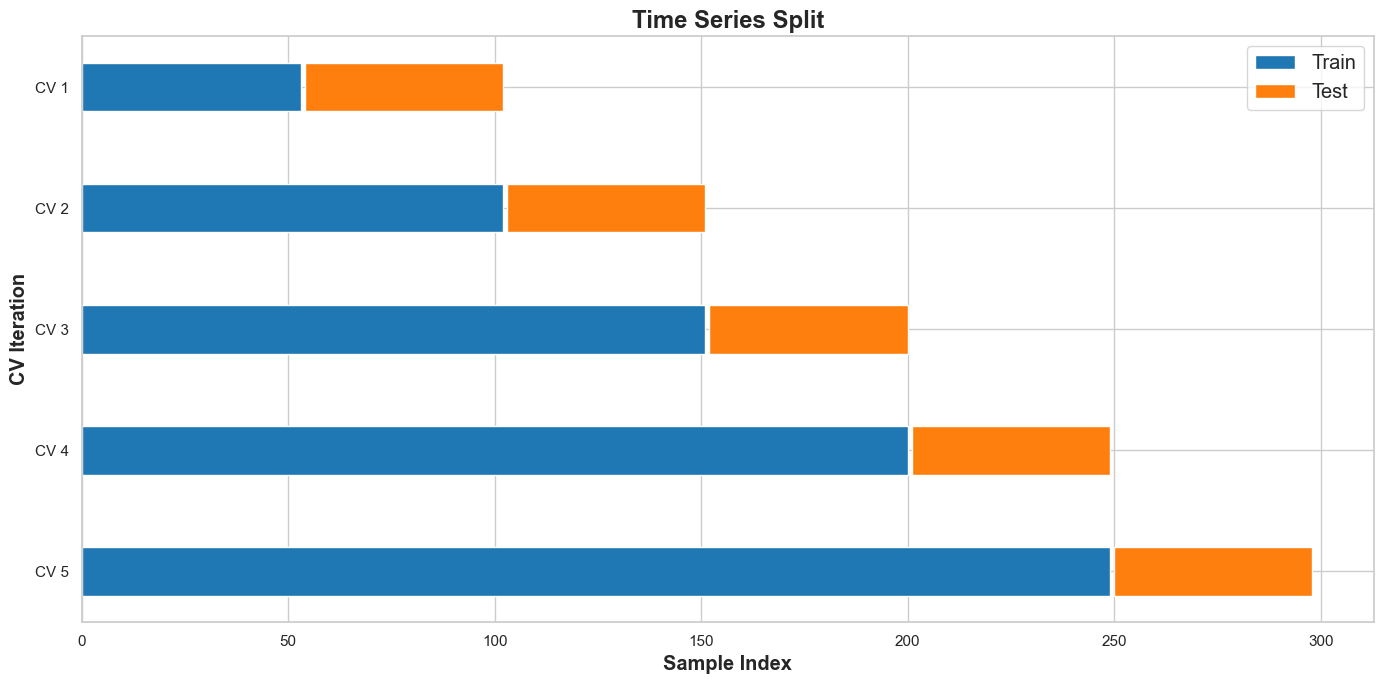

In [75]:
#Plotting our cross validation splits.

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 7))


train_color = '#1f77b4'  
test_color = '#ff7f0e'   

for i, (train_indices, test_indices) in enumerate(split_indices):
    ax.barh(y=i, width=max(train_indices)-min(train_indices), left=min(train_indices), 
            color=train_color, height=0.4, label='Train' if i == 0 else "")
    ax.barh(y=i, width=max(test_indices)-min(test_indices), left=min(test_indices), 
            color=test_color, height=0.4, label='Test' if i == 0 else "")

ax.legend(fontsize='large')
ax.set_yticks(range(len(split_indices)))
ax.set_yticklabels([f'CV {i+1}' for i in range(len(split_indices))])
ax.set_xlabel('Sample Index', fontsize='large', fontweight='bold')
ax.set_ylabel('CV Iteration', fontsize='large', fontweight='bold')
ax.set_title('Time Series Split', fontsize='x-large', fontweight='bold')

ax.invert_yaxis()
plt.tight_layout()

plt.show()


In [76]:
#Storing results and feature importance from the models
random_forest_scores = scores['RandomForest']
random_forest_feature_importances = feature_importances['RandomForest']
gradient_boosting_scores = scores['GradientBoosting']
gradient_boosting_feature_importances = feature_importances['GradientBoosting']


In [77]:
#Checking top 10 feature importances from each of our models

df_rf_top10 = feature_importances['RandomForest'].nlargest(10, 'RandomForest_Importance')
df_gb_top10 = feature_importances['GradientBoosting'].nlargest(10, 'GradientBoosting_Importance')
df_xgb_top10 = feature_importances['XGB'].nlargest(10, 'XGB_Importance')

df_rf_top10.reset_index(drop=True, inplace=True)
df_gb_top10.reset_index(drop=True, inplace=True)
df_xgb_top10.reset_index(drop=True, inplace=True)
df_top_features = pd.concat([df_rf_top10, df_gb_top10, df_xgb_top10], axis=1)

df_top_features


,Feature,RandomForest_Importance,Feature,GradientBoosting_Importance,Feature,XGB_Importance
0,indpro_report_lag3,0.033787,cpi_report_lag3,0.135650,earnings_yield_FE,0.034254
1,cpi_report_lag3,0.033188,cpi_report_lag2,0.076942,indpro_report_lag3,0.029843
2,consumer_sentiment_report_lag1,0.031922,consumer_sentiment_report_lag1,0.060845,indpro_report_lag5,0.016692
3,consumer_sentiment_report_lag4,0.029107,RSI,0.051342,consumer_sentiment_report_lag3,0.016492
4,RSI,0.028222,indpro_report_lag3,0.041002,gdp_report_lag2,0.013957
5,cpi_report_lag2,0.027844,indpro_report_lag5,0.039300,OBV,0.013298
6,cpi_report_lag1,0.026238,comm_index,0.036386,spx_vol,0.012015
7,indpro_report_lag5,0.025647,cpi_annual,0.029447,dollar_index,0.011548
8,int_rate_report_lag5,0.023714,acwi,0.028759,cpi_report_lag5,0.008925
9,comm_index,0.022801,consumer_sentiment_report_lag2,0.025414,comm_index,0.008559


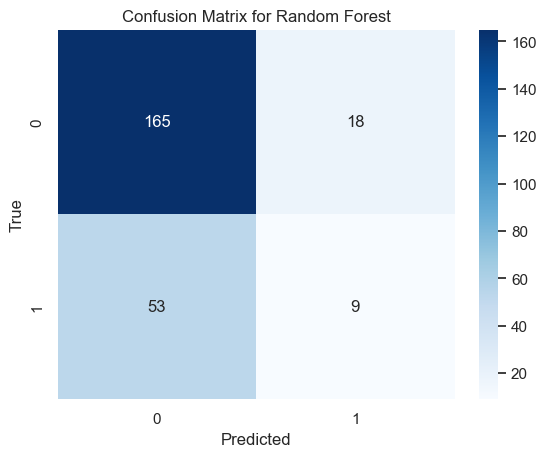

In [78]:
#Plotting the confusion matrices

cm_matrix_rf = random_forest_scores['Aggregated Confusion Matrix']

sns.heatmap(cm_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')
plt.show()

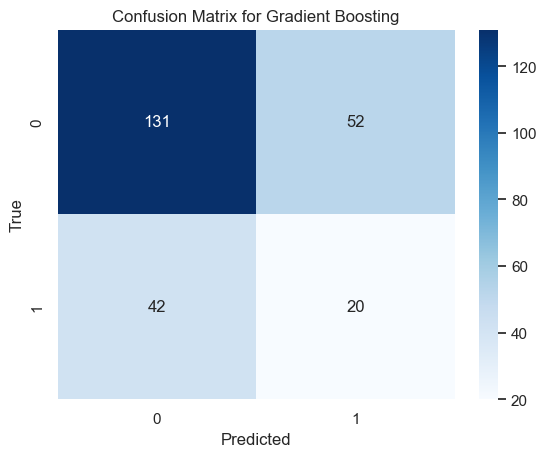

In [79]:
#Confusion matrix GB

cm_matrix_rf = gradient_boosting_scores['Aggregated Confusion Matrix']

sns.heatmap(cm_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()

In [80]:
#Here we have our hyperparameter optimization parameters to test. We will be using optuna to do that. 



def xgb_param_sample(trial):
    params = {
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.15, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 40),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'gamma': trial.suggest_float("gamma", 0, 2.0),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 20),
        'n_estimators': trial.suggest_int("n_estimators", 700, 1200),

        # some fixed hyperparameters
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
    }

    return params

def random_forest_param_sample(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 400, 500),
        'max_depth': trial.suggest_int("max_depth", 1, 100),
        'min_samples_split': trial.suggest_float("min_samples_split", 0.0000001, 0.5, log=True),
        'min_samples_leaf': trial.suggest_float("min_samples_leaf", 0.0000001, 0.5, log=True),
        'max_features': trial.suggest_float('max_features', 0.0, 1.0),
        'min_impurity_decrease': trial.suggest_float("min_impurity_decrease", 0.0000001, 1, log=True),
        'ccp_alpha': trial.suggest_float("ccp_alpha", 0.0000001, 2, log=True),
        'criterion': trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
        'n_jobs':trial.suggest_categorical('n_jobs',[-1]),
        'oob_score':trial.suggest_categorical('oob_score',[False]),
        'class_weight': trial.suggest_categorical('class_weight',[None])
 
    }
    
    return params

def gradient_boosting_param_sample(trial):
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.15, log=True),
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    return params

In [81]:
# Random Forest objective function and study

def random_forest_objective_auc(trial):
    params = random_forest_param_sample(trial)
    tscv = TimeSeriesSplit(n_splits=5)
    auc_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        weighttrain = weight_train.iloc[train_index]
        weighttest = weight_train.iloc[test_index]

        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train, sample_weight=weighttrain)

        preds = model.predict_proba(X_test)[:, 1]


        score = roc_auc_score(y_test, preds, sample_weight=weighttest)
        if not np.isnan(score):
            auc_scores.append(score)
    
    if not auc_scores:
        return np.nan

    return np.mean(auc_scores)


rf_auc_study = optuna.create_study(direction='maximize')
rf_auc_study.optimize(random_forest_objective_auc, n_trials=20)


[I 2024-03-28 19:57:49,180] A new study created in memory with name: no-name-b5af033b-3523-4d1b-95b7-1c98119dc7ce
[I 2024-03-28 19:57:51,533] Trial 0 finished with value: 0.5582089770053245 and parameters: {'n_estimators': 483, 'max_depth': 30, 'min_samples_split': 0.021851596089264163, 'min_samples_leaf': 0.0002088113708743914, 'max_features': 0.9645167062833729, 'min_impurity_decrease': 1.1776343140961972e-07, 'ccp_alpha': 2.3000060884941942e-06, 'criterion': 'gini', 'n_jobs': -1, 'oob_score': False, 'class_weight': None}. Best is trial 0 with value: 0.5582089770053245.
[I 2024-03-28 19:57:53,135] Trial 1 finished with value: 0.496217394676788 and parameters: {'n_estimators': 451, 'max_depth': 39, 'min_samples_split': 0.07277111959148538, 'min_samples_leaf': 8.582601098528198e-05, 'max_features': 0.3489010292743423, 'min_impurity_decrease': 0.0371834419947722, 'ccp_alpha': 4.610155970286835e-05, 'criterion': 'gini', 'n_jobs': -1, 'oob_score': False, 'class_weight': None}. Best is tri

In [82]:
# XGB objective function and study

def xgb_objective_auc(trial):
    params = xgb_param_sample(trial)
    tscv = TimeSeriesSplit(n_splits=5)
    auc_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        weighttrain = weight_train.iloc[train_index]
        weighttest = weight_train.iloc[test_index]

        model = XGBClassifier(**params)
        model.fit(X_train, y_train, sample_weight=weighttrain)

        preds = model.predict_proba(X_test)[:, 1]


        score = roc_auc_score(y_test, preds, sample_weight=weighttest)
        if not np.isnan(score):
            auc_scores.append(score)
    
    if not auc_scores:
        return np.nan

    return np.mean(auc_scores)


xgb_auc_study = optuna.create_study(direction='maximize')
xgb_auc_study.optimize(xgb_objective_auc, n_trials=20)


[I 2024-03-28 19:58:26,554] A new study created in memory with name: no-name-97923542-2a4f-4eb9-a6ae-94b813dabd44
[I 2024-03-28 19:58:27,637] Trial 0 finished with value: 0.5 and parameters: {'colsample_bytree': 0.8780804950620907, 'learning_rate': 0.012082426808903765, 'max_depth': 17, 'subsample': 0.7758405987369354, 'gamma': 0.33353763571382267, 'reg_lambda': 4.156749958204873e-05, 'reg_alpha': 81.7658342716625, 'min_child_weight': 17, 'n_estimators': 992}. Best is trial 0 with value: 0.5.
[I 2024-03-28 19:58:28,433] Trial 1 finished with value: 0.5 and parameters: {'colsample_bytree': 0.8036048479170216, 'learning_rate': 0.00777288586497925, 'max_depth': 12, 'subsample': 0.9499598380372346, 'gamma': 0.7416458356672546, 'reg_lambda': 6.75532163651787e-07, 'reg_alpha': 1.683852416617038e-05, 'min_child_weight': 10, 'n_estimators': 833}. Best is trial 0 with value: 0.5.
[I 2024-03-28 19:58:29,464] Trial 2 finished with value: 0.5 and parameters: {'colsample_bytree': 0.4758070158882869

In [83]:
# Gradient Boosting objective function and study

def gradient_boosting_objective_auc(trial):
    params = gradient_boosting_param_sample(trial)
    tscv = TimeSeriesSplit(n_splits=5)
    auc_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        weighttrain = weight_train.iloc[train_index]
        weighttest = weight_train.iloc[test_index]

        model = GradientBoostingClassifier(**params)
        model.fit(X_train, y_train, sample_weight=weighttrain)

        preds = model.predict_proba(X_test)[:, 1]


        score = roc_auc_score(y_test, preds, sample_weight=weighttest)
        if not np.isnan(score):
            auc_scores.append(score)
    
    if not auc_scores:
        return np.nan

    return np.mean(auc_scores)


gb_auc_study = optuna.create_study(direction='maximize')
gb_auc_study.optimize(gradient_boosting_objective_auc, n_trials=20)


[I 2024-03-28 19:58:45,503] A new study created in memory with name: no-name-9938c553-e849-42ca-ae3e-895b9e44d45e
[I 2024-03-28 19:58:47,041] Trial 0 finished with value: 0.5395296227909006 and parameters: {'learning_rate': 0.10402938896514387, 'n_estimators': 814, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 6, 'subsample': 0.9830152301935629, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5395296227909006.
[I 2024-03-28 19:58:47,506] Trial 1 finished with value: 0.5259667123689578 and parameters: {'learning_rate': 0.02384119393534646, 'n_estimators': 243, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 14, 'subsample': 0.9813648306220683, 'max_features': 'log2'}. Best is trial 0 with value: 0.5395296227909006.
[I 2024-03-28 19:58:48,102] Trial 2 finished with value: 0.4754579254849716 and parameters: {'learning_rate': 0.004919315574572826, 'n_estimators': 368, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.2260067

In [84]:
#Storing best scores and best params

rf_best_score = rf_auc_study.best_value
# xgb_best_score_auc = xgb_auc_study.best_value
gb_best_score_auc = gb_auc_study.best_value

rf_best_params_auc = rf_auc_study.best_params
# xgb_best_params_auc = xgb_auc_study.best_params
gb_best_params_auc = gb_auc_study.best_params

# Creating dictionary with each model's best parameters
model_configs = {'RandomForest': rf_best_params_auc}
# model_configs['XGB'] = xgb_best_params_auc
model_configs['GradientBoosting'] = gb_best_params_auc

In [85]:
#Parameter importance Random Forest
optuna.visualization.plot_param_importances(rf_auc_study)

In [86]:
#Parameter importance Gradient Boosting
optuna.visualization.plot_param_importances(gb_auc_study)

In [87]:
#RF optm history

optuna.visualization.plot_optimization_history(rf_auc_study)

In [88]:
#GB optm history

optuna.visualization.plot_optimization_history(gb_auc_study)

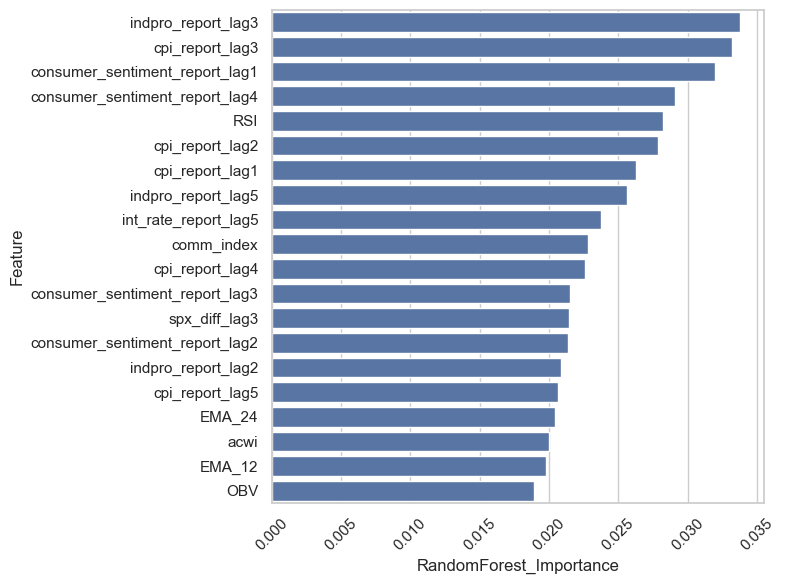

In [89]:
#Displaying RF importance in sample

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
top_n = 20
top_features_df = random_forest_feature_importances.sort_values(by='RandomForest_Importance', ascending=False).head(top_n)
sns.barplot(x='RandomForest_Importance', y='Feature', data=top_features_df)

plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()


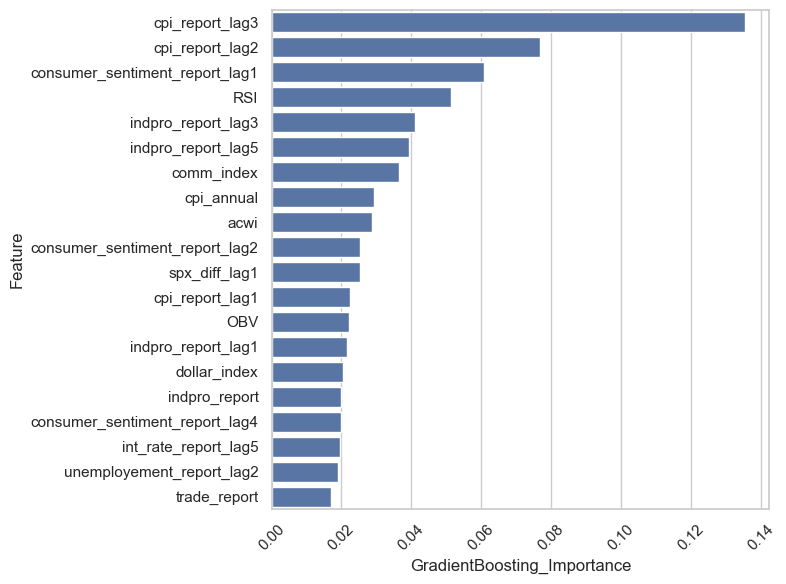

In [90]:
#Displaying GB importance 

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
top_n = 20
top_features_df_gb = gradient_boosting_feature_importances.sort_values(by='GradientBoosting_Importance', ascending=False).head(top_n)
sns.barplot(x='GradientBoosting_Importance', y='Feature', data=top_features_df_gb)

plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()

In [91]:
#This is our out of sample evaluation. It will be performed in the test set we held out.

def out_of_sample_evaluation(model_classes, X_train, y_train, X_test, y_test, random_state=1, model_configs=None, use_sample_weights=False, weight_train=None, weight_test=None):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}
    y_proba_out_of_sample = {}
    trained_models = {}
    feature_importancess = {}

    for name, model_class in model_classes.items():
        config = model_configs.get(name, {}) if model_configs is not None else {}
        config['random_state'] = random_state

        model = model_class(**config)
        if use_sample_weights:
            model.fit(X_train_scaled, y_train, sample_weight=weight_train)
        else:
            model.fit(X_train_scaled, y_train)

        if name == 'RandomForest':
            feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'feature_{i}' for i in range(X_train.shape[1])]
            estimator = model.estimators_[0]
            
            export_graphviz(estimator, out_file=f'{name}_tree.dot', 
                            feature_names=feature_names,
                            rounded=True, proportion=False, 
                            precision=2, filled=True)
            os.system(f'dot -Tpng {name}_tree.dot -o {name}_tree.png')

        trained_models[name] = model
        
        if name == 'LogisticRegression':
            if isinstance(X_train, pd.DataFrame):
                feature_names = X_train.columns
            else:
                feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
            
            coefficients = model.coef_[0]
        
            feature_importance = dict(zip(feature_names, coefficients))
            feature_importancess[name] = feature_importance


        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_proba_out_of_sample[name] = y_proba.tolist()

        y_pred_custom_threshold = (y_proba > 0.5).astype(int)

        test_accuracy = accuracy_score(y_test, y_pred_custom_threshold)
        test_auc = roc_auc_score(y_test, y_proba)
        test_log_loss = log_loss(y_test, y_proba, sample_weight=weight_test)
        test_cm = confusion_matrix(y_test, y_pred_custom_threshold)

        results[name] = {
            'Average Accuracy': test_accuracy,
            'Average Log Loss': test_log_loss,
            'Average AUC': test_auc,
            'Aggregated Confusion Matrix': test_cm.tolist(), 
        }

    return results, y_proba_out_of_sample, trained_models, feature_importancess


In [92]:
#Results with 50% probability cutoff

results, y_proba_out_of_sample,trained_models, feature_importances_out_of_sample = out_of_sample_evaluation(
    model_classes=binary_models,
    X_train=X,
    y_train=y_new,
    X_test=X_test,
    y_test=y_new_test,
    use_sample_weights=True,
    weight_train=weight_train,
    weight_test=weight_test,
    model_configs=model_configs
)
results


{'LogisticRegression': {'Average Accuracy': 0.575,
  'Average Log Loss': 1.2726929241529632,
  'Average AUC': 0.5911458333333334,
  'Aggregated Confusion Matrix': [[20, 4], [13, 3]]},
 'RandomForest': {'Average Accuracy': 0.6,
  'Average Log Loss': 0.6896538380311019,
  'Average AUC': 0.8072916666666667,
  'Aggregated Confusion Matrix': [[24, 0], [16, 0]]},
 'GradientBoosting': {'Average Accuracy': 0.6,
  'Average Log Loss': 3.248225215686369,
  'Average AUC': 0.6458333333333333,
  'Aggregated Confusion Matrix': [[23, 1], [15, 1]]},
 'XGB': {'Average Accuracy': 0.45,
  'Average Log Loss': 0.7774059856582648,
  'Average AUC': 0.390625,
  'Aggregated Confusion Matrix': [[17, 7], [15, 1]]}}

In [93]:
#Results 40% probability cutoff
results_40, y_proba_out_of_sample_40,trained_models_40, feature_importances_out_of_sample_40 = out_of_sample_evaluation(
    model_classes=binary_models,
    X_train=X,
    y_train=y_new,
    X_test=X_test,
    y_test=y_new_test,
    use_sample_weights=True,
    weight_train=weight_train,
    weight_test=weight_test,
    model_configs=model_configs
)
results_40


{'LogisticRegression': {'Average Accuracy': 0.575,
  'Average Log Loss': 1.2726929241529632,
  'Average AUC': 0.5911458333333334,
  'Aggregated Confusion Matrix': [[20, 4], [13, 3]]},
 'RandomForest': {'Average Accuracy': 0.6,
  'Average Log Loss': 0.689653838031102,
  'Average AUC': 0.8072916666666667,
  'Aggregated Confusion Matrix': [[24, 0], [16, 0]]},
 'GradientBoosting': {'Average Accuracy': 0.6,
  'Average Log Loss': 3.248225215686369,
  'Average AUC': 0.6458333333333333,
  'Aggregated Confusion Matrix': [[23, 1], [15, 1]]},
 'XGB': {'Average Accuracy': 0.45,
  'Average Log Loss': 0.7774059856582648,
  'Average AUC': 0.390625,
  'Aggregated Confusion Matrix': [[17, 7], [15, 1]]}}

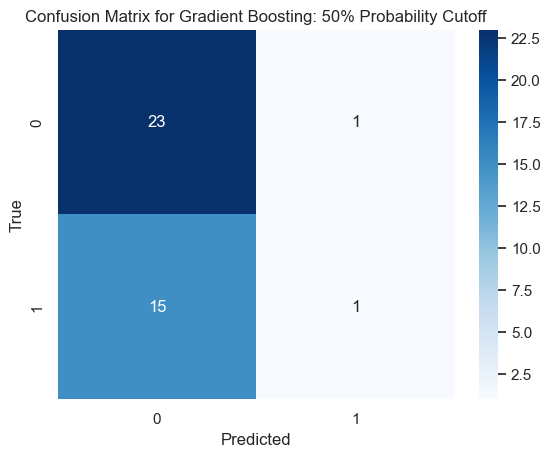

In [94]:
cm_matrix_rf_out_of_sample = results['GradientBoosting']['Aggregated Confusion Matrix']

sns.heatmap(cm_matrix_rf_out_of_sample, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gradient Boosting: 50% Probability Cutoff')
plt.show()

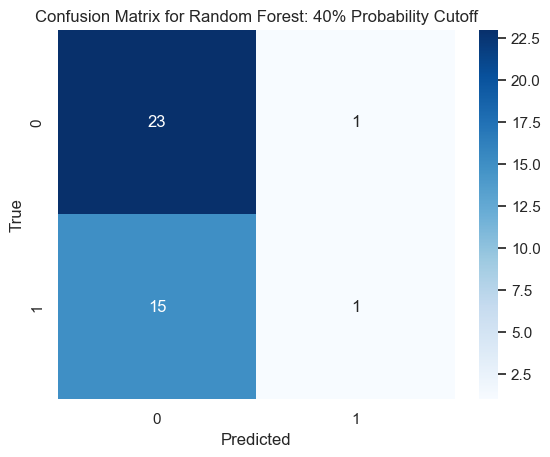

In [95]:
cm_matrix_rf_out_of_sample_40 = results_40['GradientBoosting']['Aggregated Confusion Matrix']

sns.heatmap(cm_matrix_rf_out_of_sample, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest: 40% Probability Cutoff')
plt.show()

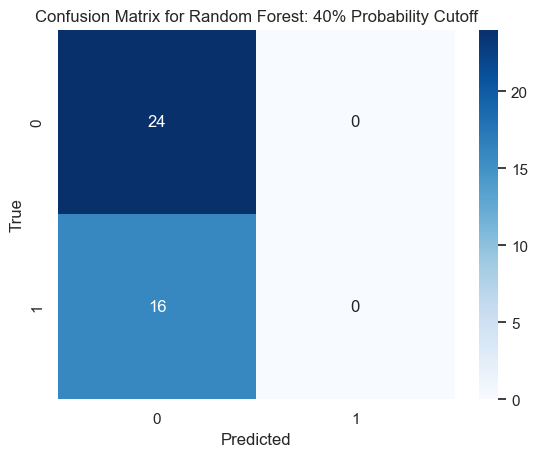

In [96]:
cm_matrix_rf_out_of_sample_40 = results_40['RandomForest']['Aggregated Confusion Matrix']

sns.heatmap(cm_matrix_rf_out_of_sample_40, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest: 40% Probability Cutoff')
plt.show()

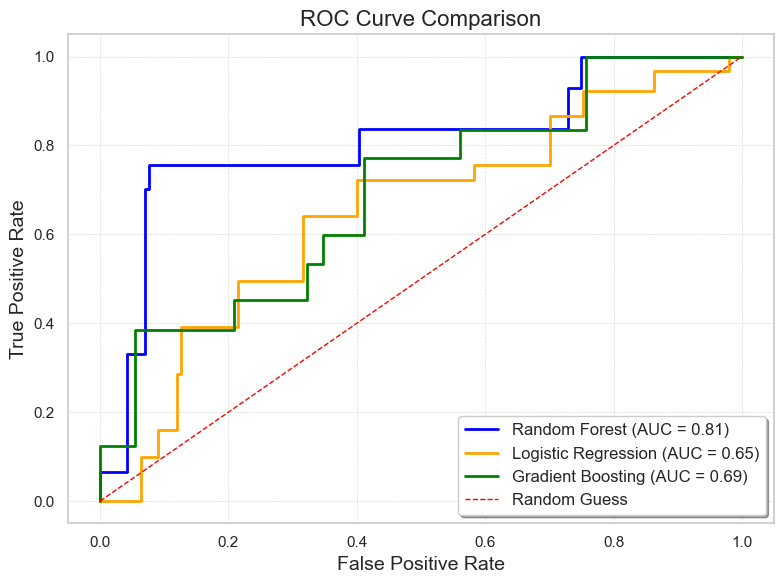

In [97]:
#Plotting ROC Curve

fpr_rf, tpr_rf, _ = roc_curve(y_new_test, y_proba_out_of_sample['RandomForest'], sample_weight=weight_test)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_new_test, y_proba_out_of_sample['LogisticRegression'], sample_weight=weight_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_gb, tpr_gb, _ = roc_curve(y_new_test, y_proba_out_of_sample['GradientBoosting'], sample_weight=weight_test)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))

plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, color='orange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_gb, tpr_gb, color='green', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')

plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random Guess')

plt.title('ROC Curve Comparison', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
plt.grid(True, linestyle='--', lw=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


/var/folders/h1/s2xd9lx97n5g9wlqw9bdxs0w0000gn/T/ipykernel_71034/3896400434.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




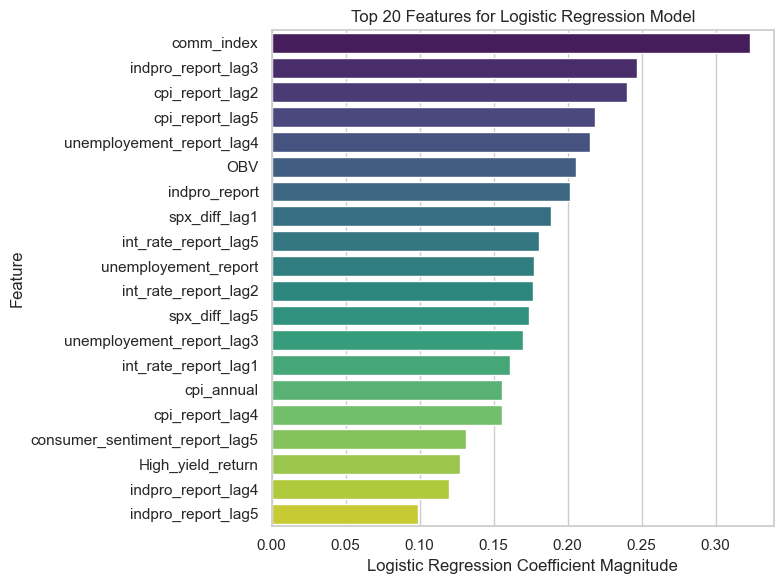

In [98]:
#Most important features Logistic regression

lr_most_important = feature_importances_out_of_sample['LogisticRegression']
feature_importances_lr = {feature: abs(coef) for feature, coef in lr_most_important.items()}

sorted_features = sorted(feature_importances_lr.items(), key=lambda item: item[1], reverse=True)

top_20_features = sorted_features[:20]

top_features_df = pd.DataFrame(top_20_features, columns=['Feature', 'Importance'])

top_features_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='viridis')

plt.xlabel('Logistic Regression Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top 20 Features for Logistic Regression Model')

plt.tight_layout()
plt.show()
